# Example-01: Objective wrapper

In [1]:
# Objective wrapper can be used to rescale input knobs, attach utility methods, handle retry, perform regularization, caching and logging.

In [2]:
# Import

import numpy
import torch

from torch import Tensor
from scipy.optimize import minimize

from rcds.wrapper import Wrapper

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

dtype = torch.float64
device = 'cpu'

True
16


In [3]:
# Define original objective function (input knobs are in original cube)
# Original objective is expected to return a (value, error) tuple of scalars
# Expected to return (tensor(nan), _) on 'failure' 

def objective(knobs:Tensor) -> tuple[Tensor, Tensor]:
    x, y = knobs
    value = (x - 5.0)**2 + (y + 5.0)**2
    error = torch.zeros_like(value)
    return value, error

# Evaluate objective

knobs = torch.tensor([+5.0, -5.0], dtype=dtype, device=device)
value, error = objective(knobs)

print(f'knobs={knobs.cpu().numpy()}')
print(f'value={value.cpu().item()}')
print(f'error={error.cpu().item()}')
print()

knobs=[ 5. -5.]
value=0.0
error=0.0



In [4]:
# Wrapper class can be used as a decorator for original objective functions
# Define wrapped objective function (input knobs are assumed to be in unit cube on invocation of wrapped objective)

@Wrapper(cache=False, sf=False, nr=0, nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[0.0, 0.0], error=1.0E-3, l1=None, l2=None, dtype=dtype, device=device)
def objective(knobs:Tensor) -> tuple[Tensor, Tensor]:
    x, y = knobs
    value = (x - 5.0)**2 + (y + 5.0)**2
    error = torch.zeros_like(value)
    return value, error

# Initial evaluation with None or without argument (attach attributes without original objective evaluation)
objective(None)

# Evaluate objective
# Knobs are rescaled with forward (original to unit) or inverse (unit to original)

knobs = torch.tensor([+5.0, -5.0], dtype=dtype, device=device)
knobs = objective.forward(knobs)
value, error = objective(knobs)

print(f'knobs={knobs.cpu().numpy()}')
print(f'value={value.cpu().item()}')
print(f'error={error.cpu().item()}')
print()

# Several attributes are attached to objective (avalible after evaluation with None or without arguments)
# Also see objective.__dict__

print(f'nk={objective.nk}')                           # nk      -- number of knobs
print(f'lb={objective.lb.cpu().numpy()}')             # lb      -- lower bounds
print(f'ub={objective.ub.cpu().numpy()}')             # ub      -- upper bounds
print(f'dk={objective.dk.cpu().numpy()}')             # dk      -- knobs significance steps (passed to wrapper in units of ogirinal knobs, attached in units of unit knobs)
print(f'error={objective.error.cpu().item()}')        # error   -- objective error (if None, error returned by original objective is used)
print(f'l1={objective.l1}')                           # l1      -- l1 regularization factor
print(f'l2={objective.l2}')                           # l2      -- l2 regularization factor
print()

# If error parameter is not None, error value returned by original objective is replaced for all subsequent evaluations
# By default, regularization parameters alpha_l1 and alpha_l2 are set to zeros
# Nonzero values can be used to add regularization penalty
# l1*sum(||knobs||_1) + l2*sum(||knobs||_2) is added to the returned value of original objective

# Rescale methods are also attached to wrapped objective (avalible after first 'evaluation')
# Rescale unit knobs and back

print(f'unit knobs {knobs.cpu().numpy()} to original knobs {objective.inverse(knobs).cpu().numpy()}')
print(f'origial knobs {objective.inverse(knobs).cpu().numpy()} to unit knobs {objective.forward(objective.inverse(knobs)).cpu().numpy()}')

knobs=[1. 0.]
value=0.0
error=0.001

nk=2
lb=[-5. -5.]
ub=[5. 5.]
dk=[0. 0.]
error=0.001
l1=None
l2=None

unit knobs [1. 0.] to original knobs [ 5. -5.]
origial knobs [ 5. -5.] to unit knobs [1. 0.]


In [5]:
# Define a numpy wrapper (can be used in scipy minimization, objective error is ignored)

def target(knobs:numpy.array, *, dtype:torch.dtype=dtype, device:torch.device=device) -> numpy.array:
    knobs = torch.tensor(knobs, dtype=dtype, device=device)
    value, _ = objective(knobs)
    return value.cpu().numpy()

knobs = numpy.array([0.5, 0.5])
result = minimize(target, knobs, method='powell')

print(result.x)
print(objective.inverse(torch.tensor(result.x, dtype=dtype, device=device)))
print(result.fun)

[1. 0.]
tensor([5.000000000000e+00, -5.000000000000e+00], dtype=torch.float64)
0.0


In [6]:
# Objective value sign flip

@Wrapper(sf=True, nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[0.1, 0.1], error=1.0E-3, dtype=dtype, device=device)
def objective(knobs:Tensor) -> tuple[Tensor, Tensor]:
    x, y = knobs
    value = (x - 5.0)**2 + (y + 5.0)**2
    error = torch.zeros_like(value)
    return -value, error

def target(knobs:numpy.array, *, dtype:torch.dtype=dtype, device:torch.device=device) -> numpy.array:
    knobs = torch.tensor(knobs, dtype=dtype, device=device)
    value, _ = objective(knobs)
    return value.cpu().numpy()

objective()
knobs = numpy.array([0.5, 0.5])
result = minimize(target, knobs, method='powell')

print(result.x)
print(objective.inverse(torch.tensor(result.x, dtype=torch.float64)))
print(result.fun)

[1. 0.]
tensor([5.000000000000e+00, -5.000000000000e+00], dtype=torch.float64)
0.0


In [7]:
# Failure handling

# By convention, original objective is expected to return (tensor(nan), _) on failuer
# In this case additional evaluations can be performed if nr parameter is not zero
# Default nr value is zero and no additional evaluations are performed if returned objective value is tensor(nan)

@Wrapper(cache=True, nr=0, nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[0.1, 0.1], error=1.0E-3)
def objective(knobs:Tensor) -> tuple[Tensor, Tensor]:
    x, y = knobs
    value = (x - 5.0)**2 + (y + 5.0)**2
    error = torch.zeros_like(value)
    value = value if torch.rand(1).item() > 0.5 else torch.tensor(float('nan'), dtype=value.dtype, device=value.device)
    return value, error


# Evaluate

objective()
knobs = torch.tensor([+5.0, -5.0], dtype=torch.float64)
knobs = objective.forward(knobs)
data = []
for _ in range(10):
    value, error = objective(knobs)
    data.append(value if value is None else value.item())
print(data)
print()

print(objective.n)
print(objective.m)
print()


# Define objective with additional evaluations

@Wrapper(cache=True, nr=100, nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[0.1, 0.1], error=1.0E-3)
def objective(knobs:Tensor) -> tuple[Tensor, Tensor]:
    x, y = knobs
    value = (x - 5.0)**2 + (y + 5.0)**2
    error = torch.zeros_like(value)
    value = value if torch.rand(1).item() > 0.5 else torch.tensor(float('nan'), dtype=value.dtype, device=value.device)
    return value, error

# Evaluate

objective()
knobs = torch.tensor([+5.0, -5.0], dtype=torch.float64)
knobs = objective.forward(knobs)
data = []
for _ in range(10):
    value, error = objective(knobs)
    data.append(value if value is None else value.item())
print(data)
print()

print(objective.n)
print(objective.m)
print()

# Number of evaluations

# Cached values
# Note, knobs values are in original box

print(objective.history_knobs)
print(objective.history_value)
print(objective.history_error)
print()

# Save knobs, value and error

knobs, value, error = objective.history()
print(knobs.cpu().numpy().tolist())
print(value.cpu().numpy().tolist())
print(error.cpu().numpy().tolist())
print()

[nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, 0.0, nan]

10
10

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

10
15

[[5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0]]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]

[[5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0]]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]



In [8]:
# Use Wrapper instance instead of a decorator

def original(knobs:Tensor) -> tuple[Tensor, Tensor]:
    x, y = knobs
    value = (x - 5.0)**2 + (y + 5.0)**2
    error = torch.zeros_like(value)
    return value, error

wrapper = Wrapper(cache=True, nr=100, nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[0.1, 0.1], error=1.0E-3)

objective = wrapper(original)
objective()

knobs = torch.tensor([+5.0, -5.0], dtype=torch.float64)
knobs = objective.forward(knobs)
value, error = objective(knobs)
print(value)
print(error)
print()

# Note, can skip rescaling (pass knobs in original cube)

wrapper = Wrapper(cache=True, nr=100, nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[0.1, 0.1], error=1.0E-3)

objective = wrapper(original, wrapped=False)
objective()

knobs = torch.tensor([+5.0, -5.0], dtype=torch.float64)
value, error = objective(knobs)
print(value)
print(error)
print()

tensor(0., dtype=torch.float64)
tensor(1.000000000000e-03, dtype=torch.float64)

tensor(0., dtype=torch.float64)
tensor(1.000000000000e-03, dtype=torch.float64)



In [9]:
# Any number of extra arguments can be passed

def original(knobs:Tensor, a:float, b:float, c:float) -> tuple[Tensor, Tensor]:
    x, y = knobs
    value = a*(x - 5.0)**2 + b*(y + 5.0)**2 + c
    error = torch.zeros_like(value)
    return value, error

wrapper = Wrapper(cache=True, nr=100, nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[0.1, 0.1], error=1.0E-3)

objective = wrapper(original)
objective()

knobs = torch.tensor([+5.0, -5.0], dtype=torch.float64)
knobs = objective.forward(knobs)
value, error = objective(knobs, 1.0, 1.0, 1.0)
print(value)
print(error)
print()

tensor(1.000000000000e+00, dtype=torch.float64)
tensor(1.000000000000e-03, dtype=torch.float64)



# Example-02: RCDS parabola workflow

In [1]:
# In this example RCDS parabola fit steps are illustrated
# RCDS optimization uses Powell's method with robust comparisons
# 1D optimization is done with minimum bracketing and (weighted) parabola fit

In [2]:
# Import

import numpy
import torch

from torch import Tensor

from rcds.statistics import mean, variance, median, biweight_midvariance
from rcds.wrapper import Wrapper
from rcds.minimizer import Minimizer

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

dtype = torch.float64
device = 'cpu'

True
16


In [3]:
# Define wrapped objective {-0.702014,{x->1.10369,y->-1.10369}}

@Wrapper(cache=True, nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[1.0E-9, 1.0E-9], error=1.0E-6, dtype=dtype, device=device)
def objective(knobs:Tensor) -> Tensor:
    x, y = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2
    error = torch.zeros_like(value)
    return value, error

# Attach attributes

objective()

# Minimizer instance

minimizer = Minimizer(objective)

# RCDS minimization (parabola fit)

# Set initial guess

knobs = torch.tensor([-3.0, 4.0], dtype=dtype, device=device)

# Transform into unit cube

knobs = objective.forward(knobs)

# Set initial search directions

matrix = torch.eye(minimizer.nk, dtype=dtype, device=device)

# Perfom minimization
# Note, (knobs, value, error, matrix) at each iteration are returned

knobs, value, error, matrix = minimizer.rcds(
    knobs,                                 # -- initial knobs
    matrix,                                # -- initial search directions
    ni=8,                                  # -- total number of iterations
    sf=0.01,                               # -- initial step fraction
    sf_min=0.001,                          # -- min step fraction
    sf_max=0.1,                            # -- max step fraction
    dr=1.00,                               # -- initial step decay rate (updated on each iteration)
    ktol=1.0E-9,                           # -- knobs termination tolerance
    otol=1.0E-6,                           # -- objective termination tolerance
    factor=1.0,                            # -- proximity factor in [0.0, 1.0]
    termination=True,                      # -- flag to use knobs and value termination
    verbose=False,                         # -- verbose flag
    pause=0.0,                             # -- pause after each iteration in seconds
    minimize=minimizer.minimize_parabola,  # -- 1D minimizer (minimize_parabola or minimize_gp) and its options
    fc=3.0,                                # -- factor to use in comparison of objective values
    np=2,                                  # -- number of points around current bracketed minimum (on each side) to use for parabola fit
    ns=4,                                  # -- number of points to add with uniform sampling in bracketed interval (defined by np)
    fr=0.1,                                # -- factor to use in comparison of close points
    ft=1.0,                                # -- threshold factor to for oulier detection
    tolerance=1.0E-06,                     # -- objective tolerance
    sample=True,                           # -- flag to add additional samples
    detector=None                          # -- outlier detector function (residual, ft, otol)
)

EXIT: triggered value termination at iteration 4


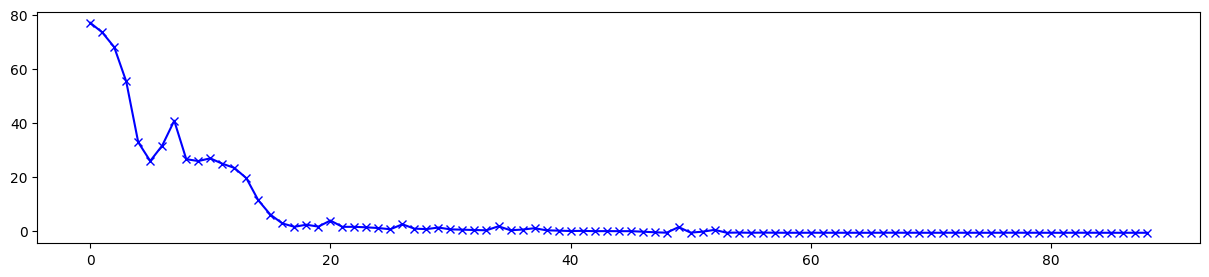

In [4]:
# Plot all objective values

plt.figure(figsize=(15, 3))
plt.plot(range(minimizer.history_neval), minimizer.history_value, color='blue', marker='x')
plt.show()

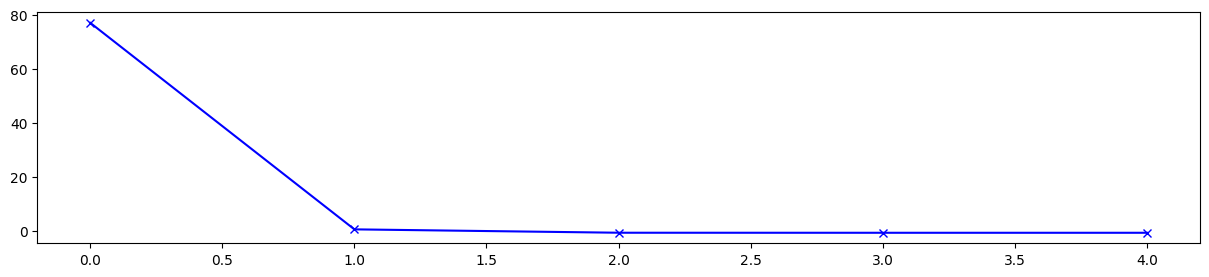

In [5]:
# Plot objective value vs iteration

plt.figure(figsize=(15, 3))
plt.plot(range(len(value)), value.cpu().numpy(), color='blue', marker='x')
plt.show()

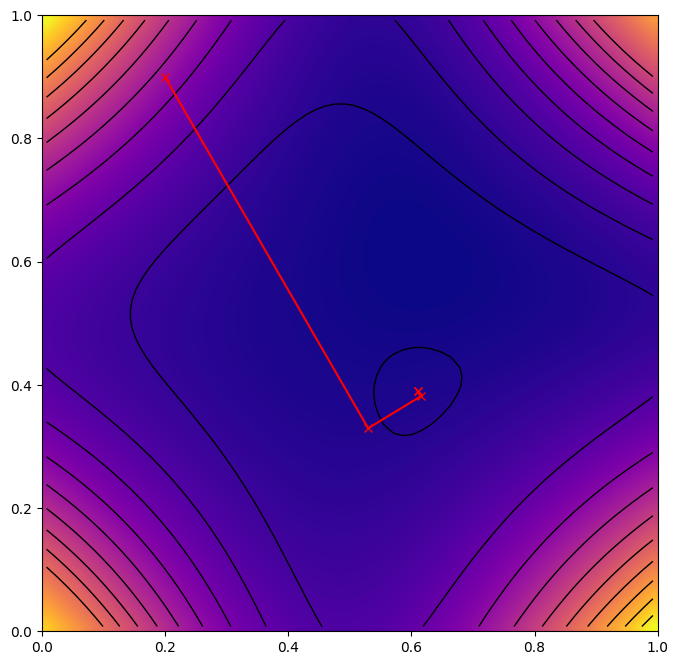

In [6]:
# Plot objective and knobs vs iteration

x = torch.linspace(1.0, 0.0, 64, dtype=dtype, device=device)
y = torch.linspace(1.0, 0.0, 64, dtype=dtype, device=device)

X, Y = torch.meshgrid(x, y, indexing='ij')

Z = torch.tensor([[objective(torch.stack([x, y])) for x, y in zip(x, y)] for x, y in zip(X, Y)])[..., 0]
L = torch.linspace(0.0, 200.0, 10, dtype=dtype, device=device)

plt.figure(figsize=(8, 8))
plt.imshow(Z.cpu().numpy(), cmap='plasma', interpolation='bilinear', origin='upper', extent=(0, 1, 0, 1))
plt.contour(Z.cpu().numpy(), L.cpu().numpy(), origin='lower', extend='both', linewidths=1, extent=(0, 1, 0, 1), colors='black')
plt.plot(*knobs.T.cpu().numpy(), color='red', marker='x')
plt.show()

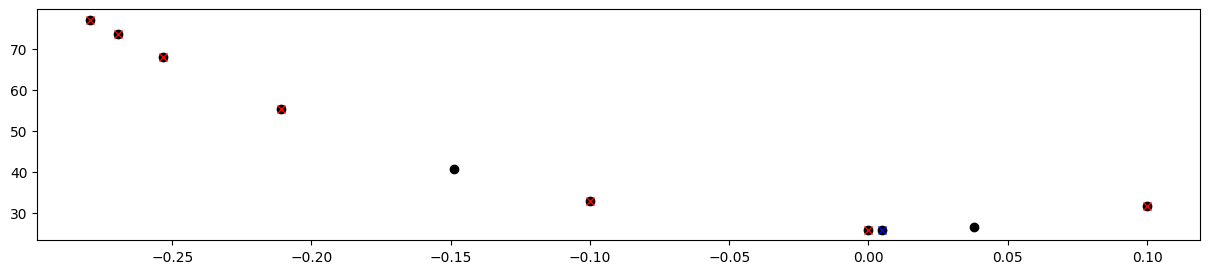

In [7]:
# Detailed 1D minimization step with parabola
# The task is to minimize objective(knobs + parameter*vector) with respect to parameter for fixed knobs (initial guess / reference point) and vector (direction)

# Minimizer instance

minimizer = Minimizer(objective)

# Set initial parameters

knobs = torch.tensor([-3.0, 4.0], dtype=dtype, device=device)
knobs = objective.forward(knobs)
value, error = objective(knobs)

vector = torch.tensor([1.0, 0.0], dtype=dtype, device=device)

# Add evaluation to history

minimizer.append(knobs, value, error)

# The first step is to bracket minimum for given initial knobs along given direction vector 
# For given initial knobs and vector, valid parameter interval (knobs' = knobs + parameter*vector) is computed (interval of parameter values for which all knobs remain in the unit cube)
# Given a step fraction, initial step is computed as (step fraction)*(valid interval length)
# Min and max steps are computed as well using min and max step fractions
# Parameter value is increased until current minimum objective value is less than the value in the positive direction (objective errors is used in comparison)
# If current objective value is less than initial objective value (objective errors is used in comparison), search is terminated
# Else parameter is decreased
# bracket() method returns a tuple of parameter values, corresponding knobs, value and error
# Zero parameter index corresponds to current objective minimum

table_alpha, table_knobs, table_value, table_error = minimizer.bracket(
    0.01,                                  # -- initial step fraction along the line
    knobs,                                 # -- initial knobs
    value,                                 # -- initial value
    error,                                 # -- initial error
    vector,                                # -- initial direction vector
    sf_min=0.001,                          # -- min step fraction
    sf_max=0.1,                            # -- max step fraction
    fc=3.0                                 # --  factor to use in comparison of objective values
)

# Next, (weighted) parabola fit is performed
# Given number of points (np) around current parameter minimum are used (on each side) to define new interval
# This interval is sampled, upto new (ns) new points are added
# If added points are close to already known points, this points are removed and objective is computed only for the rest points
# This is controlled by fr parametere
# Optimal knobs, value and error are returned (parameter value is not returned)

knobs_min, value_min, error_min = minimizer.parabola(
    vector,                                # -- initial direction vector
    table_alpha,                           # -- parameter
    table_knobs,                           # -- knobs
    table_value,                           # -- value 
    table_error,                           # -- error
    np=2,                                  # -- number of points around current bracketed minimum (on each side) to use for parabola fit
    ns=4,                                  # -- number of points to add with uniform sampling in bracketed interval (defined by np)
    fr=0.1,                                # -- factor to use in comparison of close points
    ft=1.0,                                # -- threshold factor to for oulier detection (used if detector is not None)
    tolerance=1.0E-06,                     # -- objective tolerance
    sample=True,                           # -- flag to add additional samples
    detector=None                          # -- outlier detector function (residual, ft, otol)
)

# Compute optimal parameter value from optimal knobs

alpha_min, _ = (knobs_min - table_knobs[table_alpha == 0.0].flatten())/vector

# Compute all parameters (bracketing, sampling and parabola)

knobs, value, error = minimizer.history()
alpha, _ = ((knobs - table_knobs[table_alpha == 0.0].flatten())/vector).T

# Plot result

plt.figure(figsize=(15, 3))
plt.errorbar(alpha.cpu().numpy(), value.cpu().numpy(), yerr=error.cpu().numpy(), fmt=' ', color='black', marker='o')
plt.errorbar(table_alpha.cpu().numpy(), table_value.cpu().numpy(), yerr=table_error.cpu().numpy(), fmt=' ', color='red', marker='x')
plt.errorbar(alpha_min.cpu().numpy(), value_min.cpu().numpy(), yerr=error_min.cpu().numpy(), fmt=' ', color='blue', marker='x')
plt.show()

# Red crosses are computed duaring minimum bracketing
# Blue cross corresponds to parabola minimum
# Black dots without crosses are computed duaring sampling
# Number of samples is 4, but only 2 are evaluated, since other 2 are close to existing points
# Note, for zero fr, all samples will be evaluated

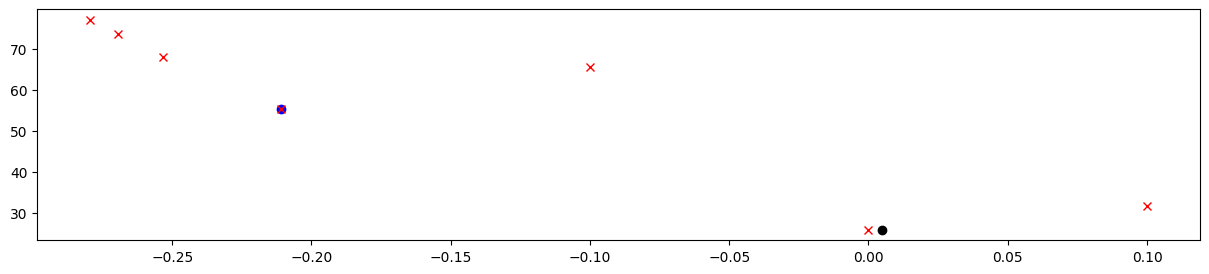

In [8]:
# Optional detector function can be passed
# This function is used to filter outliers
# After initial fit this fuction is applied to fit residuals, ft and epsilon parameters are also passed to this function
# This fuction should return a bool mask which is used to multiply weights
# Data is refitted with new weights

# Minimizer instance

minimizer = Minimizer(objective)

# Set initial parameters

knobs = torch.tensor([-3.0, 4.0], dtype=dtype, device=device)
knobs = objective.forward(knobs)
value, error = objective(knobs)

vector = torch.tensor([1.0, 0.0], dtype=dtype, device=device)

# Add evaluation to history

minimizer.append(knobs, value, error)

# Define detector function
# Note, number of samples should not be too small for correct detector performance

def detector(residual:Tensor, limit:Tensor, tolerance:Tensor) -> Tensor:
    center = median(residual)
    spread = tolerance + biweight_midvariance(residual).sqrt()
    min_value, max_value = center - limit*spread, center + limit*spread
    mask = ((residual > min_value.reshape(-1, 1))*(residual < max_value.reshape(-1, 1))).squeeze()
    return mask

# Bracket

table_alpha, table_knobs, table_value, table_error = minimizer.bracket(0.01, knobs, value, error, vector)

# Add an outlier
# Note, here outlier is added after bracketing

index = 4
table_value[index] *= 2.0

# Fit without detector

knobs_min, value_min, error_min = minimizer.parabola(vector, table_alpha, table_knobs, table_value, table_error, np=2, ns=4, fr=0.1, ft=1.0, tolerance=1.0E-06, sample=True, detector=None)
alpha_min, _ = (knobs_min - table_knobs[table_alpha == 0.0].flatten())/vector

# Fit with detector

knobs_new, value_new, error_new = minimizer.parabola(vector, table_alpha, table_knobs, table_value, table_error, np=2, ns=4, fr=0.1, ft=1.0, tolerance=1.0E-06, sample=True, detector=detector)
alpha_new, _ = (knobs_new - table_knobs[table_alpha == 0.0].flatten())/vector

# Plot result

plt.figure(figsize=(15, 3))
plt.errorbar(alpha_new.cpu().numpy(), value_new.cpu().numpy(), yerr=error_new.cpu().numpy(), fmt=' ', color='black', marker='o')
plt.errorbar(alpha_min.cpu().numpy(), value_min.cpu().numpy(), yerr=error_min.cpu().numpy(), fmt=' ', color='blue', marker='o')
plt.errorbar(table_alpha.cpu().numpy(), table_value.cpu().numpy(), yerr=table_error.cpu().numpy(), fmt=' ', color='red', marker='x')
plt.show()

# blue  -- without detector
# black -- with detector

# Example-03: RCDS basic

In [1]:
# In this example basic use case is presented

In [2]:
# Import

import numpy
import torch

from torch import Tensor

from rcds.statistics import mean, variance, median, biweight_midvariance
from rcds.wrapper import Wrapper
from rcds.minimizer import Minimizer

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

dtype = torch.float64
device = 'cpu'

True
16


In [3]:
# Minimize quadratic objective function {-2., {x -> 2., y -> -2.}}

@Wrapper(cache=True, nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[1.0E-12, 1.0E-12], error=1.0E-12, dtype=dtype, device=device)
def objective(knobs):
    x, y = knobs
    value = (x - 1.0)**2  + x*y + (y + 1.0)**2 
    error = torch.zeros_like(value)
    return value, error

# Unit vectors
# Minimum is reached at the 2nd iteration, exit trigged at the 3rd iteration

objective()

minimizer = Minimizer(objective)

knobs = torch.tensor([-3.0, 4.0], dtype=dtype, device=device)
knobs = objective.forward(knobs)

matrix = torch.eye(len(knobs), dtype=dtype, device=device)

knobs, value, error, matrix = minimizer.rcds(
    knobs,
    matrix,
    ni=8,
    sf=0.01,
    sf_min=0.001,
    sf_max=0.1,
    dr=1.00,
    ktol=1.0E-6,
    otol=1.0E-6,
    factor=0.0,
    termination=True,
    verbose=False,
    pause=0.0,
    minimize=minimizer.minimize_parabola,
    fc=3.0,
    np=2,
    ns=4,
    fr=0.1,
    ft=1.0,
    tolerance=1.0E-06,
    sample=True,
    detector=None
)

for i, (x, y) in enumerate(zip(knobs, value)):
    print(i, *objective.inverse(x).cpu().numpy(), y.cpu().numpy())
print()

# Hessian eigenvectors
# Minimum is reached at the 1st iteration, exit trigged at the 2nd iteration

objective()

minimizer = Minimizer(objective)

knobs = torch.tensor([-3.0, 4.0], dtype=dtype, device=device)
knobs = objective.forward(knobs)


hessian = torch.tensor([[2.0, 1.0], [1.0, 2.0]], dtype=dtype, device=device)
matrix = torch.real(torch.linalg.eig(hessian).eigenvectors)

knobs, value, error, matrix = minimizer.rcds(
    knobs,
    matrix,
    ni=8,
    sf=0.01,
    sf_min=0.001,
    sf_max=0.1,
    dr=1.00,
    ktol=1.0E-6,
    otol=1.0E-6,
    factor=0.0,
    termination=True,
    verbose=False,
    pause=0.0,
    minimize=minimizer.minimize_parabola,
    fc=3.0,
    np=2,
    ns=4,
    fr=0.1,
    ft=1.0,
    tolerance=1.0E-06,
    sample=True,
    detector=None
)

for i, (x, y) in enumerate(zip(knobs, value)):
    print(i, *objective.inverse(x).cpu().numpy(), y.cpu().numpy())
print()

EXIT: triggered knobs termination at iteration 3
0 -3.0 4.0 29.0
1 -0.40983606557376895 -1.8278688524590194 3.422131147540983
2 1.9999999999999973 -1.9999999999999951 -2.0
3 1.9999999999999973 -1.9999999999999951 -2.0

EXIT: triggered knobs termination at iteration 2
0 -3.0 4.0 29.0
1 2.0000000000000018 -2.0000000000000018 -2.0
2 2.0000000000000018 -2.0000000000000018 -2.0



In [4]:
# Minimize nonlinear objective function {-0.702014, {x->1.10369, y->-1.10369}}

@Wrapper(cache=True, nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[1.0E-12, 1.0E-12], error=1.0E-6, dtype=dtype, device=device)
def objective(knobs):
    x, y = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2
    error = torch.zeros_like(value)
    return value, error

# Unit vectors

objective()

minimizer = Minimizer(objective)

knobs = torch.tensor([-3.0, 4.0], dtype=dtype, device=device)
knobs = objective.forward(knobs)

matrix = torch.eye(len(knobs), dtype=dtype, device=device)

knobs, value, error, matrix = minimizer.rcds(
    knobs,
    matrix,
    ni=8,
    sf=0.01,
    sf_min=0.001,
    sf_max=0.1,
    dr=0.90,
    ktol=1.0E-6,
    otol=1.0E-3,
    factor=0.0,
    termination=True,
    verbose=False,
    pause=0.0,
    minimize=minimizer.minimize_parabola,
    fc=3.0,
    np=2,
    ns=4,
    fr=0.1,
    ft=1.0,
    tolerance=1.0E-03,
    sample=True,
    detector=None
)

for i, (x, y) in enumerate(zip(knobs, value)):
    print(i, *objective.inverse(x).cpu().numpy(), y.cpu().numpy())
print()

# Hessian eigenvectors

objective()

minimizer = Minimizer(objective)

knobs = torch.tensor([-3.0, 4.0], dtype=dtype, device=device)
knobs = objective.forward(knobs)

matrix = minimizer.matrix(knobs)

knobs, value, error, matrix = minimizer.rcds(
    knobs,
    matrix,
    ni=8,
    sf=0.01,
    sf_min=0.001,
    sf_max=0.1,
    dr=1.0,
    ktol=1.0E-6,
    otol=1.0E-3,
    factor=0.0,
    termination=True,
    verbose=False,
    pause=0.0,
    minimize=minimizer.minimize_parabola,
    fc=3.0,
    np=2,
    ns=4,
    fr=0.1,
    ft=1.0,
    tolerance=1.0E-03,
    sample=True,
    detector=None
)

for i, (x, y) in enumerate(zip(knobs, value)):
    print(i, *objective.inverse(x).cpu().numpy(), y.cpu().numpy())
print()

EXIT: triggered value termination at iteration 4
0 -3.0 4.0 77.0
1 -0.1578947368421053 -0.9134615384615383 1.4993740677604945
2 1.1397294625418937 -1.095513502230621 -0.7002836870807188
3 1.10395792359955 -1.103644285234049 -0.7020134133813323
4 1.1037781063461676 -1.1036570505644483 -0.7020134961543624

EXIT: triggered value termination at iteration 3
0 -3.0 4.0 77.0
1 1.1911225706352209 -1.101151390266165 -0.6914098273217104
2 1.1029861075085332 -1.0924498166549141 -0.7018300967246007
3 1.1040195843997438 -1.103380105232401 -0.7020132821755711



EXIT: triggered knobs termination at iteration 2
387
-309.91447934606583


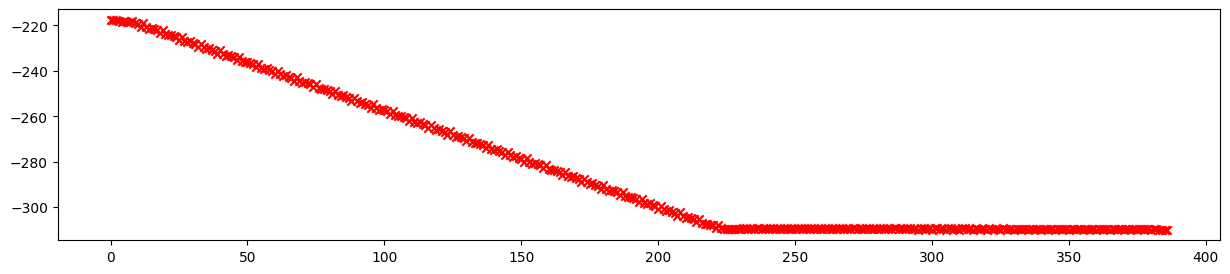

576
-309.99999999999983



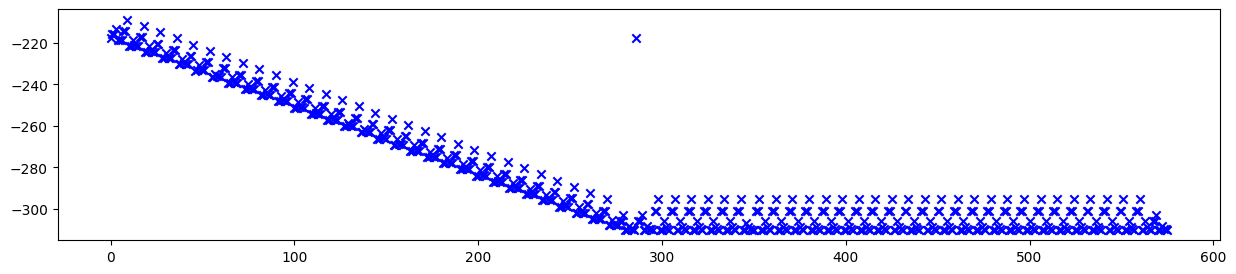

In [5]:
# Minimize multidimensional objective fuction
# Compare RCDS parabola with minimize('powell')

# Set number of knobs and knobs parameters

nk = 32
lb = [-10.0 for _ in range(nk)]
ub = [+10.0 for _ in range(nk)]
dk = [1.0E-3 for _ in range(nk)]

# Set objective function

def objective(knobs:Tensor) -> tuple[Tensor, Tensor]:
    value = torch.zeros_like(knobs.sum())
    error = torch.zeros_like(knobs.sum())
    for i in range(len(knobs) - 1):
        value -= 10.0*torch.exp(-0.25*torch.sqrt(knobs[i]**2 + knobs[i + 1]**2))
    return value, error

# RCDS

obj = Wrapper(cache=True, nk=nk, lb=lb, ub=ub, dk=dk, error=1.0E-6, dtype=dtype, device=device)(objective)
obj()

minimizer = Minimizer(obj)

knobs = torch.tensor([1.0 for _ in range(minimizer.nk)], dtype=dtype, device=device)
knobs = obj.forward(knobs)

matrix = torch.eye(minimizer.nk, dtype=dtype, device=device)

knobs, value, error, matrix = minimizer.rcds(
    knobs,
    matrix,
    ni=8,
    sf=0.005,
    sf_min=0.001,
    sf_max=0.1,
    dr=1.0,
    ktol=1.0E-3,
    otol=1.0E-3,
    factor=1.0,
    termination=True,
    verbose=False,
    pause=0.0,
    minimize=minimizer.minimize_parabola,
    fc=3.0,
    np=2,
    ns=2,
    fr=0.1,
    ft=1.0,
    tolerance=1.0E-03,
    sample=True,
    detector=None
)

print(minimizer.history_neval)
print(value[-1].cpu().item())

plt.figure(figsize=(15, 3))
plt.scatter(range(obj.n), obj.history_value, color='red', marker='x')
plt.show()

# Powell (scipy)

obj = Wrapper(cache=True, nk=nk, lb=lb, ub=ub, dk=dk, error=1.0E-6, dtype=dtype, device=device)(objective)
obj()

minimizer = Minimizer(obj)

knobs = torch.tensor([1.0 for _ in range(minimizer.nk)], dtype=dtype, device=device)
knobs = obj.forward(knobs)

matrix = torch.eye(minimizer.nk, dtype=dtype, device=device)

result = minimizer.scipy(knobs, options={'direc': matrix.numpy(), 'ftol': 1.0E-3, 'xtol':1.0E-3})
print(result.nfev)
print(result.fun)
print()

# Compare objective evaluations
# red -- rcds, blue -- powell

# Note, scipy Powell's method has a jump
# Similar jump is present in RCDS if factor = 0.0, in this example factor = 1.0 and no jump is present

# Note, scipy Powell's method has different bracketing (more explorative)

plt.figure(figsize=(15, 3))
plt.scatter(range(obj.n), obj.history_value, color='blue', marker='x')
plt.show()

141
-309.58710246782965



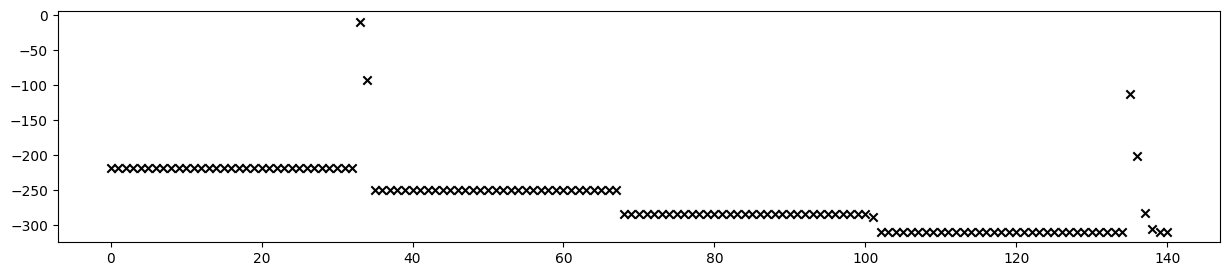

In [6]:
# Other scipy bounded minimize methods can be passed
# ('powell', 'Nelder-Mead', 'L-BFGS-B', 'TNC', 'SLSQP', 'trust-constr')

method = 'SLSQP'

obj = Wrapper(cache=True, nk=nk, lb=lb, ub=ub, dk=dk, error=1.0E-6, dtype=dtype, device=device)(objective)
obj()

minimizer = Minimizer(obj)

knobs = torch.tensor([1.0 for _ in range(minimizer.nk)], dtype=dtype, device=device)
knobs = obj.forward(knobs)

result = minimizer.scipy(knobs, method=method, tol=1.0E-3)
print(result.nfev)
print(result.fun)
print()

plt.figure(figsize=(15, 3))
plt.scatter(range(obj.n), obj.history_value, color='black', marker='x')
plt.show()

# Example-04: RCDS for noisy objective

In [1]:
# In this example application of RCDS (and comparison with regular Powell's method) is shown for noisy objective

In [2]:
# Import

import numpy
import torch

from torch import Tensor

from rcds.statistics import mean, variance, median, biweight_midvariance
from rcds.wrapper import Wrapper
from rcds.minimizer import Minimizer

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

dtype = torch.float64
device = 'cpu'

True
16


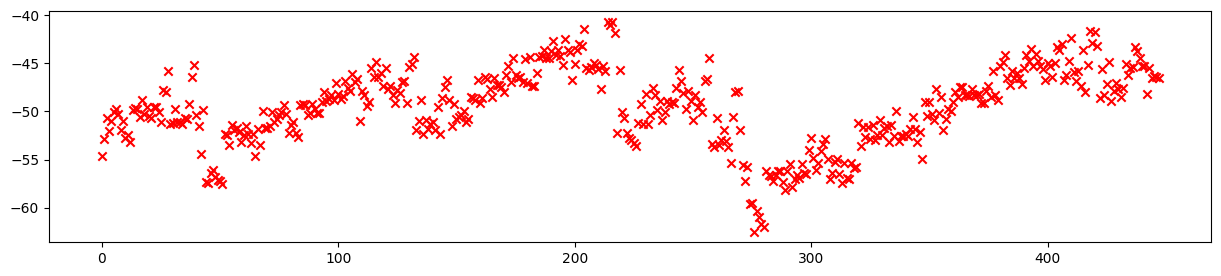

In [3]:
# Powell (scipy)

nk = 32
lb = [-50.0 for _ in range(nk)]
ub = [+50.0 for _ in range(nk)]
dk = [1.0E-3 for _ in range(nk)]

error = 1.0

@Wrapper(cache=True, nk=nk, lb=lb, ub=ub, dk=dk, error=error, dtype=dtype, device=device)
def objective(knobs:Tensor, error=error) -> tuple[Tensor, Tensor]:
    value = torch.zeros_like(knobs.sum())
    error = error*torch.ones_like(knobs.sum())
    for i in range(len(knobs) - 1):
        value -= 10.0*torch.exp(-0.25*torch.sqrt(knobs[i]**2 + knobs[i + 1]**2))
    return value + error*torch.randn_like(error), error

objective()
minimizer = Minimizer(objective)

knobs = torch.tensor([5.0 for _ in range(minimizer.nk)], dtype=dtype, device=device)
knobs = objective.forward(knobs)

matrix = torch.eye(minimizer.nk, dtype=minimizer.dtype)

result = minimizer.scipy(knobs, options={'direc': matrix.numpy(), 'ftol': 1.0, 'xtol':1.0E-3})


plt.figure(figsize=(15, 3))
plt.scatter(range(objective.n), objective.history_value, color='red', marker='x')
plt.show()

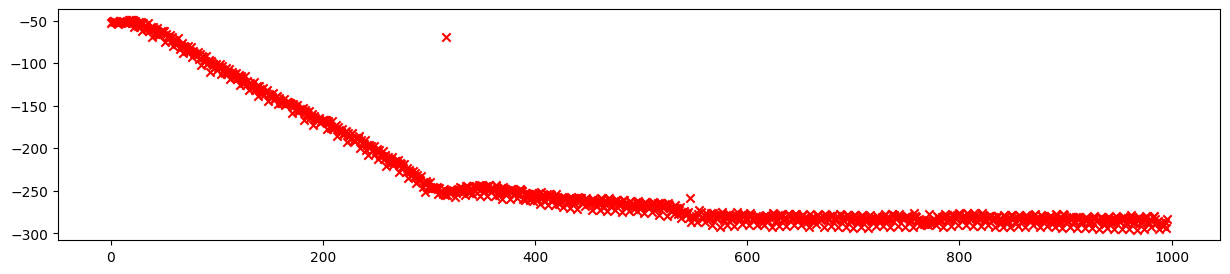

In [4]:
# RCDS (parabola fit)

nk = 32
lb = [-50.0 for _ in range(nk)]
ub = [+50.0 for _ in range(nk)]
dk = [1.0E-3 for _ in range(nk)]

error = 1.0

@Wrapper(cache=True, nk=nk, lb=lb, ub=ub, dk=dk, error=error, dtype=dtype, device=device)
def objective(knobs:Tensor, error=error) -> tuple[Tensor, Tensor]:
    value = torch.zeros_like(knobs.sum())
    error = error*torch.ones_like(knobs.sum())
    for i in range(len(knobs) - 1):
        value -= 10.0*torch.exp(-0.25*torch.sqrt(knobs[i]**2 + knobs[i + 1]**2))
    return value + error*torch.randn_like(error), error

objective()
minimizer = Minimizer(objective)

knobs = torch.tensor([5.0 for _ in range(minimizer.nk)], dtype=dtype, device=device)
knobs = objective.forward(knobs)

matrix = torch.eye(minimizer.nk, dtype=dtype, device=device)

knobs, value, error, matrix = minimizer.rcds(
    knobs,
    matrix,
    ni=4,
    sf=0.05,
    sf_min=0.001,
    sf_max=0.1,
    dr=1.0,
    ktol=1.0E-3,
    otol=1.0E-3,
    factor=0.0,
    termination=False,
    verbose=False,
    pause=0.0,
    minimize=minimizer.minimize_parabola,
    fc=3.0,
    np=2,
    ns=6,
    fr=0.1,
    ft=1.0,
    tolerance=error,
    sample=True,
    detector=None
)

plt.figure(figsize=(15, 3))
plt.scatter(range(objective.n), objective.history_value, color='red', marker='x')
plt.show()

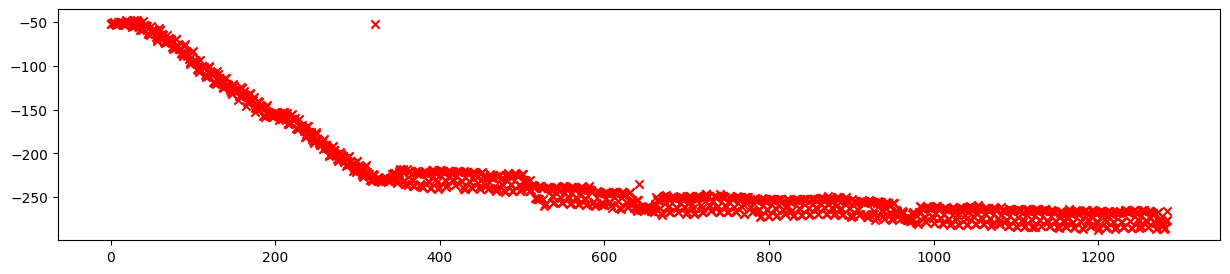

In [5]:
# RCDS (gp)

nk = 32
lb = [-50.0 for _ in range(nk)]
ub = [+50.0 for _ in range(nk)]
dk = [1.0E-3 for _ in range(nk)]

error = 1.0

@Wrapper(cache=True, nk=nk, lb=lb, ub=ub, dk=dk, error=error, dtype=dtype, device=device)
def objective(knobs:Tensor, error=error) -> tuple[Tensor, Tensor]:
    value = torch.zeros_like(knobs.sum())
    error = error*torch.ones_like(knobs.sum())
    for i in range(len(knobs) - 1):
        value -= 10.0*torch.exp(-0.25*torch.sqrt(knobs[i]**2 + knobs[i + 1]**2))
    return value + error*torch.randn_like(error), error

objective()
minimizer = Minimizer(objective)

knobs = torch.tensor([5.0 for _ in range(minimizer.nk)], dtype=dtype, device=device)
knobs = objective.forward(knobs)

matrix = torch.eye(minimizer.nk, dtype=dtype, device=device)

knobs, value, error, matrix = minimizer.rcds(
    knobs,
    matrix,
    ni=4,
    sf=0.05,
    sf_min=0.001,
    sf_max=0.1,
    dr=1.0,
    ktol=1.0E-3,
    otol=error,
    factor=0.0,
    termination=False,
    verbose=False,
    pause=0.0,
    minimize=minimizer.minimize_gp,
    no_ucb=8,
    no_ei=2,
    nr=64,
    rs=256,
    beta=1.0,
    use_parabola=False,
    np=1
)

plt.figure(figsize=(15, 3))
plt.scatter(range(objective.n), objective.history_value, color='red', marker='x')
plt.show()

# Example-05: RCDS cube operations

In [1]:
# Initial searh cube might not be optimal
# It can be too large or minimum value can be outside of the box
# In this example search box reduction and extension is illustrated
# Note, this doesn't guaranty global optimization

# Several iterations are performed, evaluation history is used to find (robust) center and spread of knobs
# New box [center - factor*spread, center + factor*spread] can be defined
# This box can be trimmed to remain in the unit cube

In [2]:
# Import

import numpy
import torch

from torch import Tensor

from rcds.statistics import mean, variance, median, biweight_midvariance
from rcds.wrapper import Wrapper
from rcds.minimizer import Minimizer

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

dtype = torch.float64
device = 'cpu'

True
16


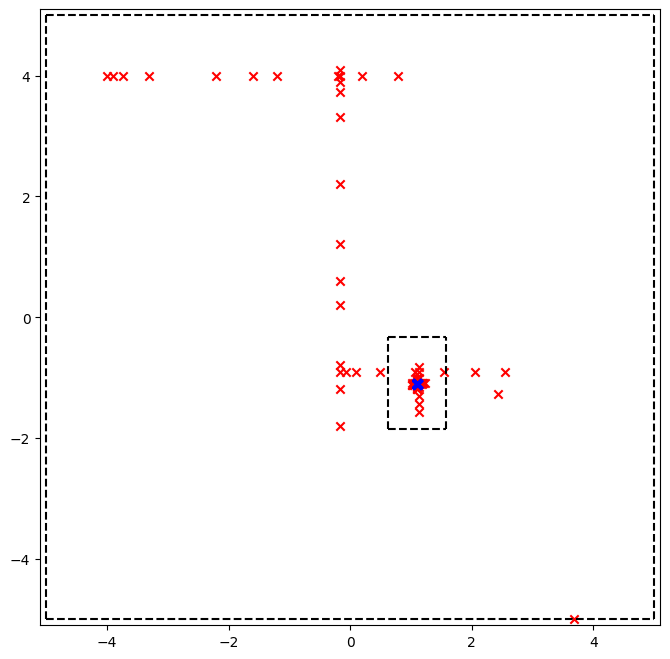

In [3]:
# Cube reduction

xmin, xmax = -5.0, 5.0
ymin, ymax = -5.0, 5.0

plt.figure(figsize=(8, 8))

plt.xlim(-5.1, 5.1)
plt.ylim(-5.1, 5.1)

plt.hlines([ymin, ymax], xmin, xmax, linestyles='dashed', color='black')
plt.vlines([xmin, xmax], ymin, ymax, linestyles='dashed', color='black')

# Perform several iterations within initial cube

@Wrapper(cache=True, nk=2, lb=[xmin, ymin], ub=[xmax, ymax], dk=[1.0E-12, 1.0E-12], error=1.0E-12, dtype=dtype, device=device)
def objective(knobs):
    x, y = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2
    error = torch.zeros_like(value)
    return value, error

objective()

minimizer = Minimizer(objective)

knobs = torch.tensor([-4.0, 4.0], dtype=dtype, device=device)
knobs = objective.forward(knobs)
matrix = torch.eye(minimizer.nk, dtype=dtype, device=device)

knobs, value, *_ = minimizer.rcds(knobs, matrix, ni=4, dr=0.95, factor=0.0, termination=False)

plt.scatter(*numpy.array(objective.history_knobs).T, color='red', marker='x')

# New cube

lb, ub = minimizer.adjust_cube()
xmin, ymin = lb
xmax, ymax = ub

plt.hlines([ymin, ymax], xmin, xmax, linestyles='dashed', color='black')
plt.vlines([xmin, xmax], ymin, ymax, linestyles='dashed', color='black')

# Perform several iterations within the new cube

knobs = objective.inverse(knobs[value == value.min()]).squeeze()

@Wrapper(cache=True, nk=2, lb=[xmin, ymin], ub=[xmax, ymax], dk=[1.0E-12, 1.0E-12], error=1.0E-12, dtype=dtype, device=device)
def objective(knobs):
    x, y = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2
    error = torch.zeros_like(value)
    return value, error

objective()

minimizer = Minimizer(objective)

knobs = objective.forward(knobs)
matrix = torch.eye(minimizer.nk, dtype=dtype, device=device)

knobs, value, *_ = minimizer.rcds(knobs, matrix, ni=4, dr=0.95, factor=0.0, termination=False)

plt.scatter(*numpy.array(objective.history_knobs).T, color='blue', marker='x')

plt.show()

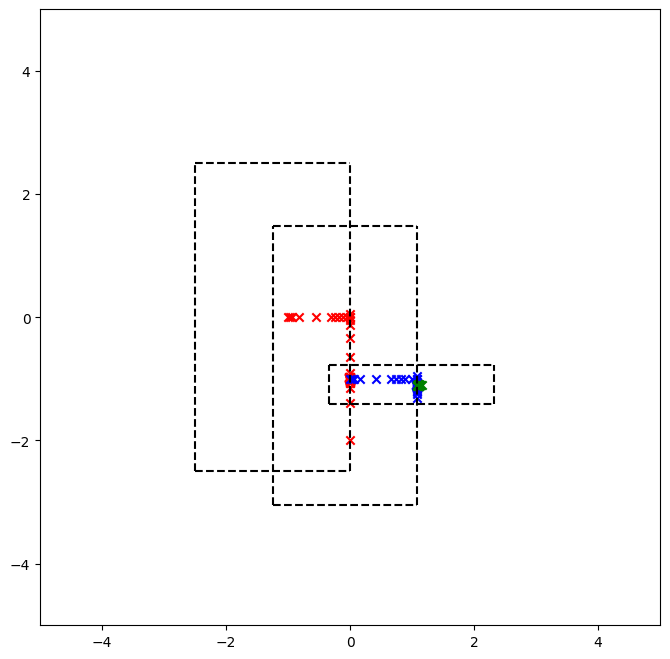

In [4]:
# Minimum outside of the cube

xmin, xmax = -2.5, 0.0
ymin, ymax = -2.5, 2.5

plt.figure(figsize=(8, 8))

plt.xlim(-5.0, 5.0)
plt.ylim(-5.0, 5.0)

plt.hlines([ymin, ymax], xmin, xmax, linestyles='dashed', color='black')
plt.vlines([xmin, xmax], ymin, ymax, linestyles='dashed', color='black')

@Wrapper(cache=True, nk=2, lb=[xmin, ymin], ub=[xmax, ymax], dk=[1.0E-12, 1.0E-12], error=1.0E-12, dtype=dtype, device=device)
def objective(knobs):
    x, y = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2
    error = torch.zeros_like(value)
    return value, error

objective()

minimizer = Minimizer(objective)

knobs = torch.tensor([-1.0, 0.0], dtype=dtype, device=device)
knobs = objective.forward(knobs)
matrix = torch.eye(minimizer.nk, dtype=dtype, device=device)

knobs, value, *_ = minimizer.rcds(knobs, matrix, ni=4, dr=0.95, factor=0.0, termination=False)

plt.scatter(*numpy.array(objective.history_knobs).T, color='red', marker='x')

# New cube

lb, ub = minimizer.adjust_cube(extend=True, factor=5.0, center=mean, spread=variance)
xmin, ymin = lb
xmax, ymax = ub

plt.hlines([ymin, ymax], xmin, xmax, linestyles='dashed', color='black')
plt.vlines([xmin, xmax], ymin, ymax, linestyles='dashed', color='black')

# Perform several iterations within the new cube

knobs, *_ = knobs[value == value.min()]
knobs = objective.inverse(knobs)

@Wrapper(cache=True, nk=2, lb=[xmin, ymin], ub=[xmax, ymax], dk=[1.0E-12, 1.0E-12], error=1.0E-12, dtype=dtype, device=device)
def objective(knobs):
    x, y = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2
    error = torch.zeros_like(value)
    return value, error

objective()

minimizer = Minimizer(objective)

knobs = objective.forward(knobs)
matrix = torch.eye(minimizer.nk, dtype=dtype, device=device)

knobs, value, *_ = minimizer.rcds(knobs, matrix, ni=4, dr=0.95, factor=0.0, termination=False)

plt.scatter(*numpy.array(objective.history_knobs).T, color='blue', marker='x')

# New cube

lb, ub = minimizer.adjust_cube(extend=True, factor=5.0, center=mean, spread=variance)
xmin, ymin = lb
xmax, ymax = ub

plt.hlines([ymin, ymax], xmin, xmax, linestyles='dashed', color='black')
plt.vlines([xmin, xmax], ymin, ymax, linestyles='dashed', color='black')

# Perform several iterations within the new cube

knobs, *_ = knobs[value == value.min()]
knobs = objective.inverse(knobs)

@Wrapper(cache=True, nk=2, lb=[xmin, ymin], ub=[xmax, ymax], dk=[1.0E-12, 1.0E-12], error=1.0E-12, dtype=dtype, device=device)
def objective(knobs):
    x, y = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2
    error = torch.zeros_like(value)
    return value, error

objective()

minimizer = Minimizer(objective)

knobs = objective.forward(knobs)
matrix = torch.eye(minimizer.nk, dtype=dtype, device=device)

knobs, value, *_ = minimizer.rcds(knobs, matrix, ni=4, dr=0.95, factor=0.0, termination=False)

plt.scatter(*numpy.array(objective.history_knobs).T, color='green', marker='x')

plt.show()

# Example-06: RCDS continious optimization

In [1]:
# Import

import numpy
import torch

from torch import Tensor

from rcds.statistics import mean, variance, median, biweight_midvariance
from rcds.wrapper import Wrapper
from rcds.minimizer import Minimizer

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

dtype = torch.float64
device = 'cpu'

True
16


In [2]:
# Define an objective (slow drift)

@Wrapper(cache=True, nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[1.0E-12, 1.0E-12], error=1.0E-12, dtype=dtype, device=device)
def objective(knobs):
    global time
    x, y = knobs
    value = (x + 1.0 + time)**2 + (y - 1.0 + time)**2 + x*y + 1.0/3.0*x**2*y**2
    time += 1.0E-3
    error = torch.zeros_like(value)
    return value, error

In [3]:
# Use large number of iterations without termination

time = 0.0
objective()
minimizer = Minimizer(objective)
knobs = torch.tensor([-3.0, 4.0], dtype=dtype, device=device)
knobs = objective.forward(knobs)
matrix = torch.eye(minimizer.nk, dtype=dtype, device=device)
knobs, value, *_ = minimizer.rcds(knobs, matrix, ni=128, dr=1.0, factor=0.0, termination=False)
knobs, value, error = objective.history()
time

1.5939999999999352

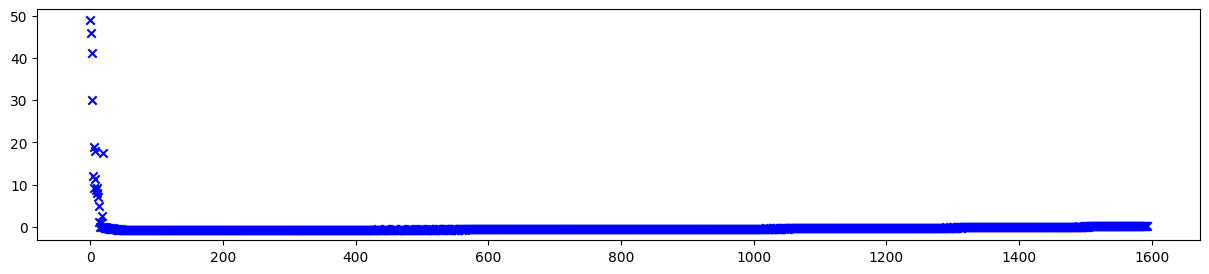

In [4]:
# Plot cached objective values

plt.figure(figsize=(15, 3))
plt.scatter(range(objective.n), value.cpu().numpy(), color='blue', marker='x')
plt.show()

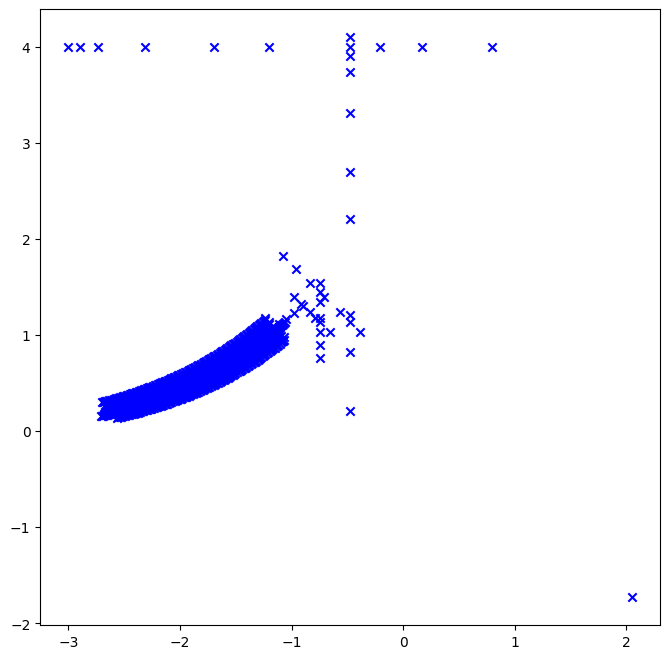

In [5]:
# Plot cached knobs

plt.figure(figsize=(8, 8))
plt.scatter(*knobs.T.cpu().numpy(), color='blue', marker='x')
plt.show()

In [6]:
# Use small number of iterations in a loop

time = 0.0
objective()
minimizer = Minimizer(objective)
knobs = torch.tensor([-3.0, 4.0], dtype=dtype, device=device)
knobs = objective.forward(knobs)
matrix = torch.eye(minimizer.nk, dtype=dtype, device=device)

for _ in range(16):
    knobs, value, _, matrix = minimizer.rcds(knobs, matrix, ni=8, dr=1.00, factor=0.0, termination=False)
    *_, knobs = knobs
    *_, value = value
    *_, matrix = matrix

knobs, value, error = objective.history()
time

1.604999999999934

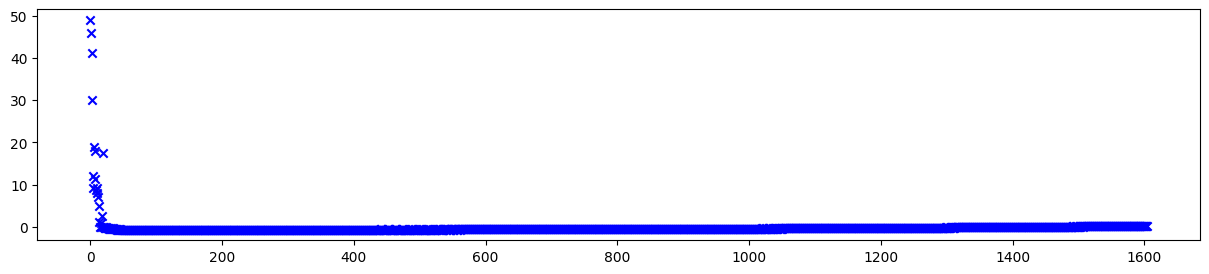

In [7]:
# Plot cached objective values

plt.figure(figsize=(15, 3))
plt.scatter(range(objective.n), value.cpu().numpy(), color='blue', marker='x')
plt.show()

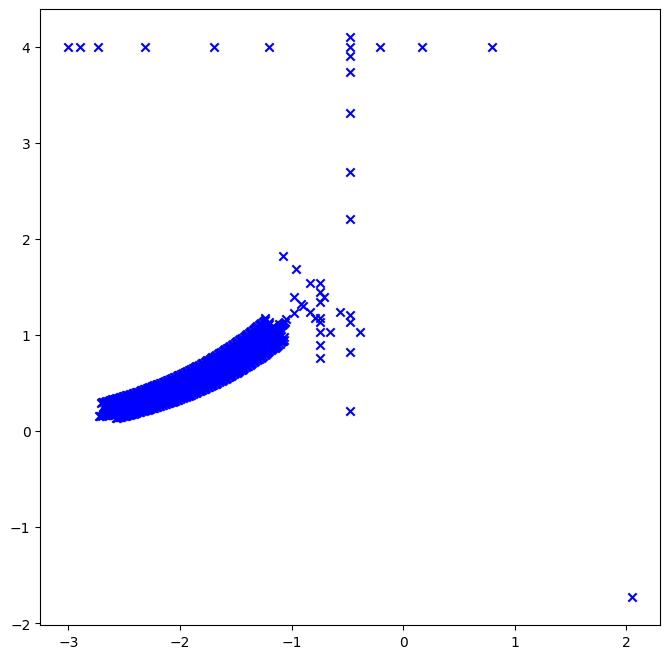

In [8]:
# Plot cached knobs

plt.figure(figsize=(8, 8))
plt.scatter(*knobs.T.cpu().numpy(), color='blue', marker='x')
plt.show()

# Example-07: RCDS with regularization

In [1]:
# Import

import numpy
import torch

from torch import Tensor

from rcds.statistics import mean, variance, median, biweight_midvariance
from rcds.wrapper import Wrapper
from rcds.minimizer import Minimizer

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

dtype = torch.float64
device = 'cpu'

True
16


In [2]:
# Without regularization

@Wrapper(nk=3, lb=[-5.0, -5.0, -5.0], ub=[+5.0, +5.0, +5.0], dk=[1.0E-12, 1.0E-12, 1.0E-12], error=1.0E-12, dtype=dtype, device=device)
def objective(knobs):
    x, y, z = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + (x*y + 1.0/3.0*x**2*y**2) + 1.0E-3*(z - 4.0)**2
    error = torch.zeros_like(value)
    return value, error

objective()

minimizer = Minimizer(objective)

knobs = torch.tensor([-3.0, 4.0, -5.0], dtype=dtype, device=device)
knobs = objective.forward(knobs)

matrix = torch.eye(minimizer.nk, dtype=dtype, device=device)

knobs, value, *_ = minimizer.rcds(knobs, matrix, ni=32, ktol=1.0E-6, otol=1.0E-6, termination=False)
*_, knobs = knobs
*_, value = value

print(*objective.inverse(knobs).cpu().numpy(), value.cpu().numpy())
print()

# l1 regularization

@Wrapper(nk=3, lb=[-5.0, -5.0, -5.0], ub=[+5.0, +5.0, +5.0], dk=[1.0E-12, 1.0E-12, 1.0E-12], error=1.0E-12, l1=1.0E-2, dtype=dtype, device=device)
def objective(knobs):
    x, y, z = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2 + 1.0E-6*(z - 1.0)**2
    error = torch.zeros_like(value)
    return value, error

objective()

minimizer = Minimizer(objective)

knobs = torch.tensor([-3.0, 4.0, -5.0], dtype=dtype, device=device)
knobs = objective.forward(knobs)

matrix = torch.eye(minimizer.nk, dtype=dtype, device=device)

knobs, value, *_ = minimizer.rcds(knobs, matrix, ni=32, ktol=1.0E-6, otol=1.0E-6, termination=False)
*_, knobs = knobs
*_, value = value

print(*objective.inverse(knobs).cpu().numpy(), value.cpu().numpy())
print()

# l2 regularization

@Wrapper(nk=3, lb=[-5.0, -5.0, -5.0], ub=[+5.0, +5.0, +5.0], dk=[1.0E-12, 1.0E-12, 1.0E-12], error=1.0E-12, l2=1.0E-2, dtype=dtype, device=device)
def objective(knobs):
    x, y, z = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2 + 1.0E-6*(z - 1.0)**2
    error = torch.zeros_like(value)
    return value, error

objective()

minimizer = Minimizer(objective)

knobs = torch.tensor([-3.0, 4.0, -5.0], dtype=dtype, device=device)
knobs = objective.forward(knobs)

matrix = torch.eye(minimizer.nk, dtype=dtype, device=device)

knobs, value, *_ = minimizer.rcds(knobs, matrix, ni=32, ktol=1.0E-6, otol=1.0E-6, termination=False)
*_, knobs = knobs
*_, value = value

print(*objective.inverse(knobs).cpu().numpy(), value.cpu().numpy())
print()

# l1 & l2 regularization

@Wrapper(nk=3, lb=[-5.0, -5.0, -5.0], ub=[+5.0, +5.0, +5.0], dk=[1.0E-12, 1.0E-12, 1.0E-12], error=1.0E-12, l1=1.0E-2, l2=1.0E-2, dtype=dtype, device=device)
def objective(knobs):
    x, y, z = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2 + 1.0E-6*(z - 1.0)**2
    error = torch.zeros_like(value)
    return value, error

objective()

minimizer = Minimizer(objective)

knobs = torch.tensor([-3.0, 4.0, -5.0], dtype=dtype, device=device)
knobs = objective.forward(knobs)

matrix = torch.eye(minimizer.nk, dtype=dtype, device=device)

knobs, value, *_ = minimizer.rcds(knobs, matrix, ni=32, ktol=1.0E-6, otol=1.0E-6, termination=False)
*_, knobs = knobs
*_, value = value

print(*objective.inverse(knobs).cpu().numpy(), value.cpu().numpy())
print()

1.1040802340883848 -1.1036282892150377 4.000000000000501 -0.7020133069636627

1.1011209380679379 -1.100704422029199 0.0009298409015503495 -0.6799582927500095

1.0973289540182574 -1.0958503631978793 9.999000105143097e-05 -0.6777881634832577

1.0947288653928275 -1.0942813024847076 0.0002974413834948564 -0.6558714261324718



# Example-08: GP minimization (1D)

In [1]:
# Import

import numpy
import torch

from torch import Tensor

from gpytorch.mlls import ExactMarginalLogLikelihood

from botorch.models import SingleTaskGP
from botorch.models import FixedNoiseGP
from botorch.fit import fit_gpytorch_model
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.acquisition.analytic import UpperConfidenceBound
from botorch.optim import optimize_acqf

from rcds.statistics import mean, variance, median, biweight_midvariance
from rcds.wrapper import Wrapper
from rcds.minimizer import Minimizer

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

dtype = torch.float64
device = 'cpu'

True
16


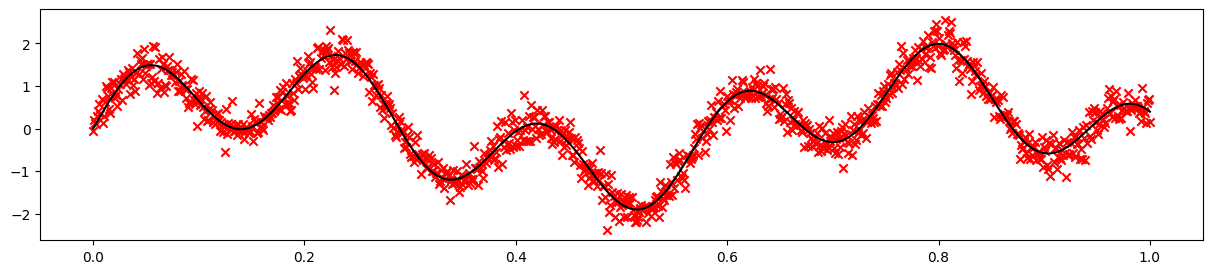

In [2]:
# Define objective function

@Wrapper(nk=1, lb=[0.0], ub=[10.0], dk=[0.0], error=0.25, dtype=dtype, device=device)
def objective(knobs):
    x, *_ = knobs
    value = torch.sin(x) + torch.sin((10.0/3.0)*x)
    global error
    if error:
        value += objective.error*torch.randn_like(value)
    return value, objective.error
objective()

# Plot objective function

plt.figure(figsize=(15, 3))

error = False
x1 = torch.linspace(0.0, 1.0, 1000, dtype=dtype, device=device)
y1, _ = torch.tensor([objective(knobs) for knobs in x1]).T
plt.plot(x1, y1, color='black')

error = True
x2 = torch.linspace(0.0, 1.0, 1000, dtype=dtype, device=device)
y2, _ = torch.tensor([objective(knobs) for knobs in x2]).T
plt.scatter(x2, y2, color='red', marker='x')

plt.show()

In [3]:
%%time

# SingleTaskGP optimization loop
# Perform 1 initial observation
# 100 observations with ExpectedImprovement
# 100 observations with UpperConfidenceBound

# Reset objective

objective()

# Set number of initial observations

ns = 10

# Generate initial knobs
# x -- original knobs, X -- rescaled knobs

x = torch.rand((ns, 1), dtype=dtype, device=device)*(objective.lb - objective.ub) + objective.ub
X = torch.stack([objective.forward(knobs) for knobs in x])

# Generate initial observations
# y -- objective values, Y -- standardized objective values

y, _ = torch.tensor([objective(knobs) for knobs in X]).T
Y = ((y - y.mean())/y.std()).nan_to_num()

# Define GP model

gp = SingleTaskGP(X, Y.reshape(-1, 1))

# Define likelihood

ll = ExactMarginalLogLikelihood(gp.likelihood, gp)

# Fit

fit_gpytorch_model(ll)

# Set number of optimization observations

no = 200

# Optimization loop

for i in range(no):
    
    # Set current best observation
    
    best = torch.min(Y)
    
    # Set acquisition function
    
    af = ExpectedImprovement(gp, best, maximize=False) if i < 100 else UpperConfidenceBound(gp, 1.0, maximize=False)
    
    # Optimize acquisition function
    
    candidate, _ = optimize_acqf(
        af,
        bounds = torch.tensor([[0.0], [1.0]], dtype=dtype, device=device),
        num_restarts = 32,
        q = 1,
        raw_samples = 128
    )
    candidate = candidate.flatten()
    
    # Perform observation for found candidate
    
    value, error = objective(candidate)
    
    # Add candidate to knobs
    
    x = torch.cat([x, objective.inverse(candidate).reshape(-1, 1)])
    X = torch.cat([X, candidate.reshape(-1, 1)])
    
    # Add objective value
    
    y = torch.cat([y, value.flatten()])
    
    # Standardize
    
    Y = ((y - y.mean())/y.std()).nan_to_num()
    
    # Update & fit model
    
    gp = SingleTaskGP(X, Y.reshape(-1, 1))
    ll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(ll)
    
    # Continue

CPU times: user 7min 56s, sys: 2.46 s, total: 7min 58s
Wall time: 30.4 s


In [4]:
# Number of objective evaluations

print(objective.n)

# Best solution

index = y.argmin()
print(f'knobs={X[index].cpu().numpy()}')
print(f'value={y[index].cpu().numpy()}')

210
knobs=[0.51566987]
value=-2.490895862209478


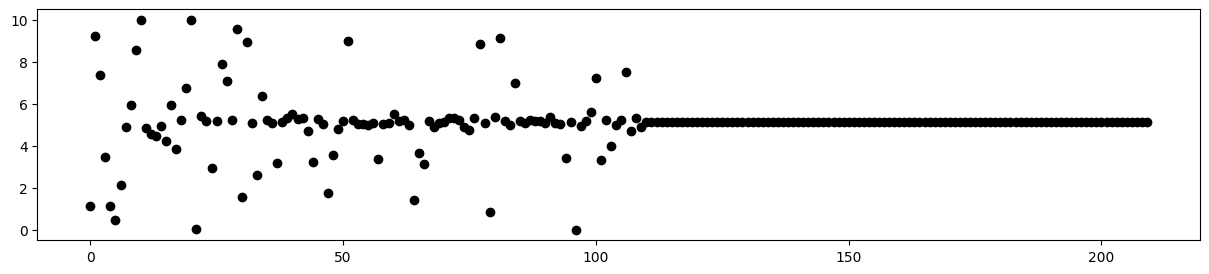

In [5]:
# Plot knob value vs time

plt.figure(figsize=(15, 3))
plt.scatter(range(objective.n), x.cpu().numpy(), color='black')
plt.show()

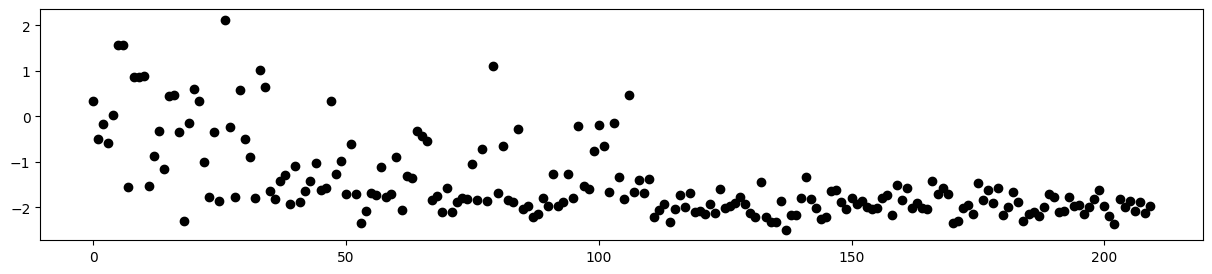

In [6]:
# Plot objective value vs time

plt.figure(figsize=(15, 3))
plt.scatter(range(objective.n), y.cpu().numpy(), color='black')
plt.show()

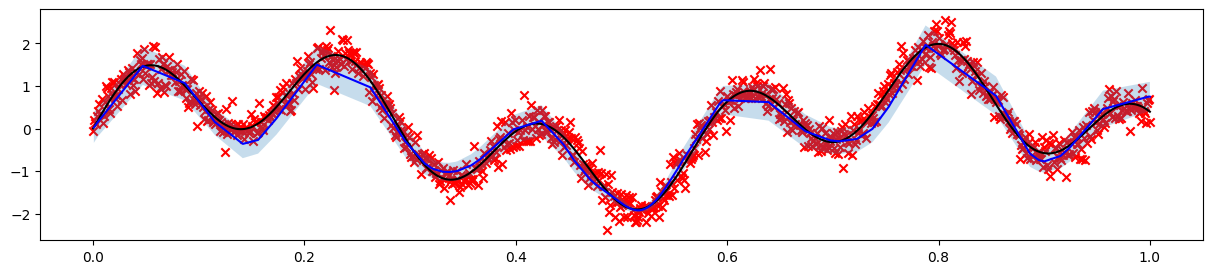

In [7]:
# Compute and plot confidence region

with torch.no_grad():
    p = gp.posterior(X, Y)
    m = p.mean.flatten()
    l, u = p.mvn.confidence_region()
    l = l.flatten()
    u = u.flatten()
    
# Sort and perform inverse standartization

index = X.flatten().argsort()
m = m[index]*y.std() + y.mean()
l = l[index]*y.std() + y.mean()
u = u[index]*y.std() + y.mean()

# Plot

plt.figure(figsize=(15, 3))
plt.plot(x1, y1, color='black')
plt.scatter(x2, y2, color='red', marker='x')
plt.plot(X.flatten()[index], m, color='blue')
plt.fill_between(X.flatten()[index], l, u, alpha = 0.25, lw = 0)
plt.show()

In [8]:
%%time

# FixedNoiseGP optimization loop
# Perform 1 initial observation
# 100 observations with ExpectedImprovement
# 100 observations with UpperConfidenceBound

# Reset objective

objective()

# Set number of initial observations

ns = 10

# Generate initial knobs
# x -- original knobs, X -- rescaled knobs

x = torch.rand((ns, 1), dtype=dtype, device=device)*(objective.lb - objective.ub) + objective.ub
X = torch.stack([objective.forward(knobs) for knobs in x])

# Generate initial observations
# y -- objective values, Y -- standardized objective values

y, s = torch.tensor([objective(knobs) for knobs in X]).T
Y = ((y - y.mean())/y.std()).nan_to_num()
S = (s/y.std()).nan_to_num()

# Define GP model

gp = FixedNoiseGP(X, Y.reshape(-1, 1), S.reshape(-1, 1)**2)

# Define likelihood

ll = ExactMarginalLogLikelihood(gp.likelihood, gp)

# Fit

fit_gpytorch_model(ll)

# Set number of optimization observations

no = 200

# Optimization loop

for i in range(no):
    
    # Set current best observation
    
    best = torch.min(Y)
    
    # Set acquisition function
    
    af = ExpectedImprovement(gp, best, maximize=False) if i < 100 else UpperConfidenceBound(gp, 1.0, maximize=False)
    
    # Optimize acquisition function
    
    candidate, _ = optimize_acqf(
        af,
        bounds = torch.tensor([[0.0], [1.0]], dtype=dtype, device=device),
        num_restarts = 32,
        q = 1,
        raw_samples = 128
    )
    candidate = candidate.flatten()
    
    # Perform observation for found candidate
    
    value, error = objective(candidate)
    
    # Add candidate to knobs
    
    x = torch.cat([x, objective.inverse(candidate).reshape(-1, 1)])
    X = torch.cat([X, candidate.reshape(-1, 1)])
    
    # Add objective value
    
    y = torch.cat([y, value.flatten()])
    s = torch.cat([s, error.flatten()])
    
    # Standardize
    
    Y = ((y - y.mean())/y.std()).nan_to_num()
    S = (s/y.std()).nan_to_num()
    
    # Update & fit model
    
    gp = FixedNoiseGP(X, Y.reshape(-1, 1), S.reshape(-1, 1)**2)
    ll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(ll)
    
    # Continue

CPU times: user 3min 23s, sys: 1.12 s, total: 3min 24s
Wall time: 13 s


In [9]:
# Number of objective evaluations

print(objective.n)

# Best solution

index = y.argmin()
print(f'knobs={X[index].cpu().numpy()}')
print(f'value={y[index].cpu().numpy()}')

210
knobs=[0.51696156]
value=-2.412567059381134


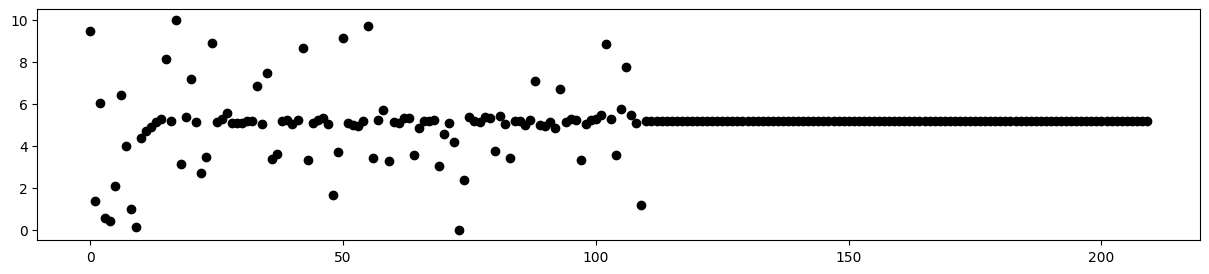

In [10]:
# Plot knob value vs time

plt.figure(figsize=(15, 3))
plt.scatter(range(objective.n), x.cpu().numpy(), color='black')
plt.show()

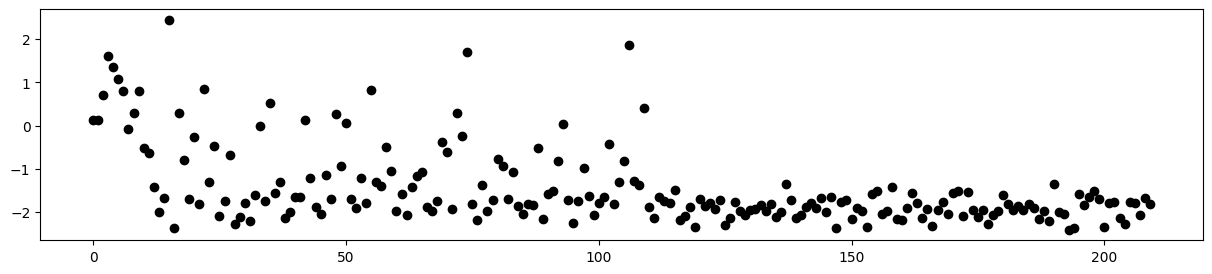

In [11]:
# Plot objective value vs time

plt.figure(figsize=(15, 3))
plt.scatter(range(objective.n), y.cpu().numpy(), color='black')
plt.show()

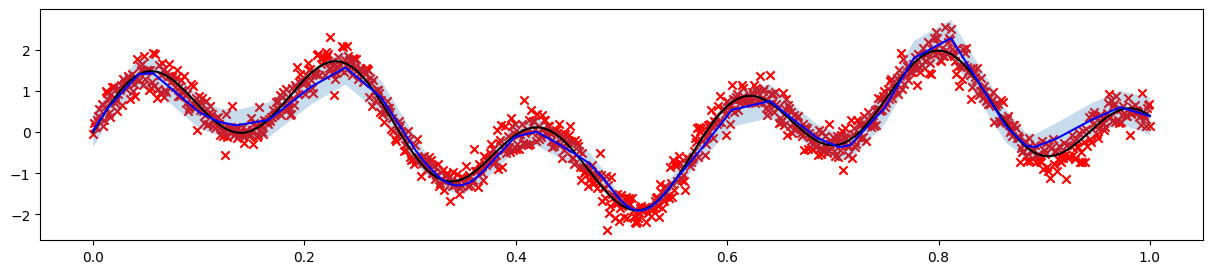

In [12]:
# Compute and plot confidence region

with torch.no_grad():
    p = gp.posterior(X, Y)
    m = p.mean.flatten()
    l, u = p.mvn.confidence_region()
    l = l.flatten()
    u = u.flatten()
    
# Sort and perform inverse standartization

index = X.flatten().argsort()
m = m[index]*y.std() + y.mean()
l = l[index]*y.std() + y.mean()
u = u[index]*y.std() + y.mean()

# Plot

plt.figure(figsize=(15, 3))
plt.plot(x1, y1, color='black')
plt.scatter(x2, y2, color='red', marker='x')
plt.plot(X.flatten()[index], m, color='blue')
plt.fill_between(X.flatten()[index], l, u, alpha = 0.25, lw = 0)
plt.show()

# Example-09: GP minimization (ND)

In [1]:
# In this example GP is used for ND minimization

In [2]:
# Import

import numpy
import torch

from torch import Tensor

from gpytorch.mlls import ExactMarginalLogLikelihood, PredictiveLogLikelihood

from botorch.models import SingleTaskGP
from botorch.models import FixedNoiseGP
from botorch.models import SaasFullyBayesianSingleTaskGP
from botorch.fit import fit_gpytorch_model, fit_fully_bayesian_model_nuts
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.acquisition.analytic import UpperConfidenceBound
from botorch.optim import optimize_acqf

from rcds.statistics import mean, variance, median, biweight_midvariance
from rcds.wrapper import Wrapper
from rcds.minimizer import Minimizer

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

dtype = torch.float64
device = 'cpu'

True
16


In [3]:
# Define objective function

nk = 3
lb = [-10.0 for _ in range(nk)]
ub = [+10.0 for _ in range(nk)]
dk = [1.0E-3 for _ in range(nk)]

@Wrapper(nk=nk, lb=lb, ub=ub, dk=dk, error=1.0E-6, dtype=dtype, device=device)
def objective(knobs:Tensor) -> tuple[Tensor, Tensor]:
    value = torch.zeros_like(knobs.sum())
    error = torch.zeros_like(knobs.sum())
    for i in range(len(knobs) - 1):
        value -= 10.0*torch.exp(-0.25*torch.sqrt(knobs[i]**2 + knobs[i + 1]**2))
    return value, error
objective()

In [4]:
# Fit with powell

minimizer =  Minimizer(objective)
knobs = torch.tensor([1.0 for _ in range(minimizer.nk)], dtype=dtype, device=device)
knobs = objective.forward(knobs)
result = minimizer.scipy(knobs)
print(result.fun)
print(result.x)

-20.0
[0.5 0.5 0.5]


In [5]:
%%time

# SingleTaskGP optimization loop

# Reset objective

objective()

# Set number of initial observations

ns = 5

# Generate initial knobs
# x -- original knobs, X -- rescaled knobs

x = torch.rand((ns, nk), dtype=dtype, device=device)*(objective.lb - objective.ub) + objective.ub
X = torch.stack([objective.forward(knobs) for knobs in x])

# Generate initial observations
# y -- objective values, Y -- standardized objective values

y, _ = torch.tensor([objective(knobs) for knobs in X], dtype=dtype, device=device).T
Y = ((y - y.mean())/y.std()).nan_to_num()

# Define GP model

gp = SingleTaskGP(X, Y.reshape(-1, 1))

# Define likelihood

ll = ExactMarginalLogLikelihood(gp.likelihood, gp)

# Fit

fit_gpytorch_model(ll)

# Set number of optimization observations

no = 200

# Optimization loop

for i in range(no):
    
    # Set current best observation
    
    best = torch.min(Y)
    
    # Set acquisition function
        
    af = ExpectedImprovement(gp, best, maximize=False) if i < 100 else UpperConfidenceBound(gp, 1.0, maximize=False)
    
    # Optimize acquisition function
    
    candidate, _ = optimize_acqf(
        af,
        bounds = torch.stack([torch.zeros_like(objective.lb), torch.ones_like(objective.ub)]),
        num_restarts = 32,
        q = 1,
        raw_samples = 128
    )
    candidate = candidate.flatten()
    
    # Perform observation for found candidate
    
    value, error = objective(candidate)
    
    # Add candidate to knobs
    
    x = torch.cat([x, objective.inverse(candidate).reshape(1, -1)])
    X = torch.cat([X, candidate.reshape(1, -1)])
    
    # Add objective value
    
    y = torch.cat([y, value.flatten()])
    
    # Standardize
    
    Y = ((y - y.mean())/y.std()).nan_to_num()
    
    # Update & fit model
    
    gp = SingleTaskGP(X, Y.reshape(-1, 1))
    ll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(ll)
    
    # Continue

CPU times: user 22min 12s, sys: 8.04 s, total: 22min 20s
Wall time: 1min 25s


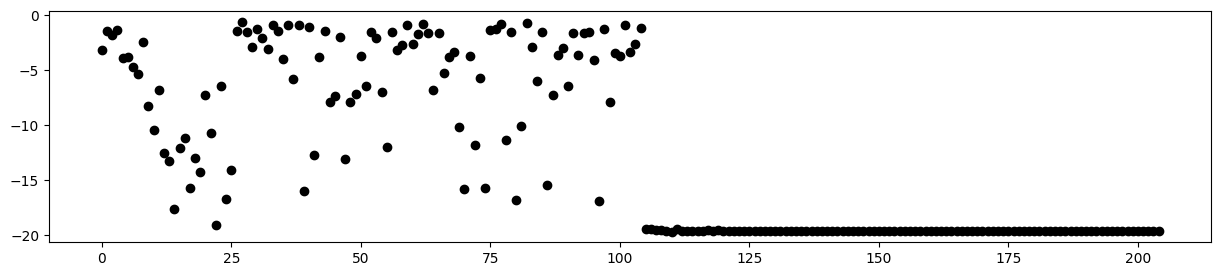

In [6]:
# Plot objective value vs time

plt.figure(figsize=(15, 3))
plt.scatter(range(objective.n), y.cpu().numpy(), color='black')
plt.show()

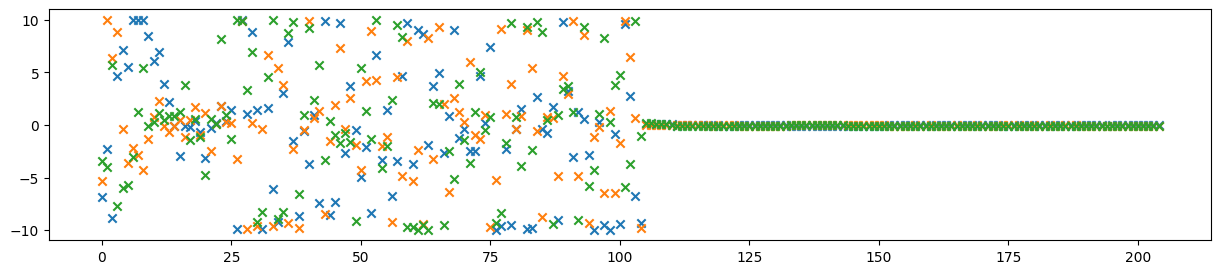

In [7]:
# Plot knobs vs time

plt.figure(figsize=(15, 3))
for k in x.T.cpu().numpy():
    plt.scatter(range(objective.n), k, marker='x')
plt.show()

In [8]:
# SaasFullyBayesianSingleTaskGP

In [9]:
# Define objective function

nk = 16
lb = [-10.0 for _ in range(nk)]
ub = [+10.0 for _ in range(nk)]
dk = [1.0E-3 for _ in range(nk)]

@Wrapper(nk=nk, lb=lb, ub=ub, dk=dk, error=1.0E-6, dtype=dtype, device=device)
def objective(knobs:Tensor) -> tuple[Tensor, Tensor]:
    value = torch.zeros_like(knobs.sum())
    error = torch.zeros_like(knobs.sum())
    for i in range(len(knobs) - 1):
        value -= 10.0*torch.exp(-0.25*torch.sqrt(knobs[i]**2 + knobs[i + 1]**2))
    return value, error
objective()

In [10]:
# Fit with powell

minimizer =  Minimizer(objective)
knobs = torch.tensor([1.0 for _ in range(minimizer.nk)], dtype=dtype, device=device)
knobs = objective.forward(knobs)
result = minimizer.scipy(knobs)
print(result.fun)
print(result.x)
print(objective.n)

-149.99999999999983
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
349


In [11]:
%%time

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# SaasFullyBayesianSingleTaskGP optimization loop

# Reset objective

objective()

# Set number of initial observations

ns = 5

# Generate initial knobs
# x -- original knobs, X -- rescaled knobs

x = torch.rand((ns, nk), dtype=dtype, device=device)*(objective.lb - objective.ub) + objective.ub
X = torch.stack([objective.forward(knobs) for knobs in x])

# Generate initial observations
# y -- objective values, Y -- standardized objective values

y, _ = torch.tensor([objective(knobs) for knobs in X], dtype=dtype, device=device).T
Y = ((y - y.mean())/y.std()).nan_to_num()

# Define GP model

gp = SaasFullyBayesianSingleTaskGP(X, Y.reshape(-1, 1))

# Fit

fit_fully_bayesian_model_nuts(gp, warmup_steps=256, num_samples=128, jit_compile=True)

# Set number of optimization observations

no = 200

# Optimization loop

for i in range(no):
    
    # Set current best observation
    
    best = torch.min(Y)
    
    # Set acquisition function
        
    af = UpperConfidenceBound(gp, 16.0, maximize=False) if i < no/2 else UpperConfidenceBound(gp, 1.0, maximize=False)
    
    # Optimize acquisition function
    
    candidate, _ = optimize_acqf(
        af,
        bounds = torch.stack([torch.zeros_like(objective.lb), torch.ones_like(objective.ub)]),
        num_restarts = 16,
        q = 1,
        raw_samples = 64
    )
    candidate = candidate.flatten()
    
    # Perform observation for found candidate
    
    value, error = objective(candidate)
    
    # Add candidate to knobs
    
    x = torch.cat([x, objective.inverse(candidate).reshape(1, -1)])
    X = torch.cat([X, candidate.reshape(1, -1)])
    
    # Add objective value
    
    y = torch.cat([y, value.flatten()])
    
    # Standardize
    
    Y = ((y - y.mean())/y.std()).nan_to_num()
    
    # Update & fit model
    
    gp = SaasFullyBayesianSingleTaskGP(X, Y.reshape(-1, 1))
    fit_fully_bayesian_model_nuts(gp, warmup_steps=256, num_samples=128, jit_compile=True)
    
    # Continue

Sample: 100%|██████████████████████████████████████████| 384/384 [00:38,  9.99it/s, step size=3.36e-01, acc. prob=0.911]                                                                                       

CPU times: user 21h 56min 58s, sys: 8min 34s, total: 22h 5min 32s
Wall time: 1h 28min 15s


In [12]:
print(objective.n)

205


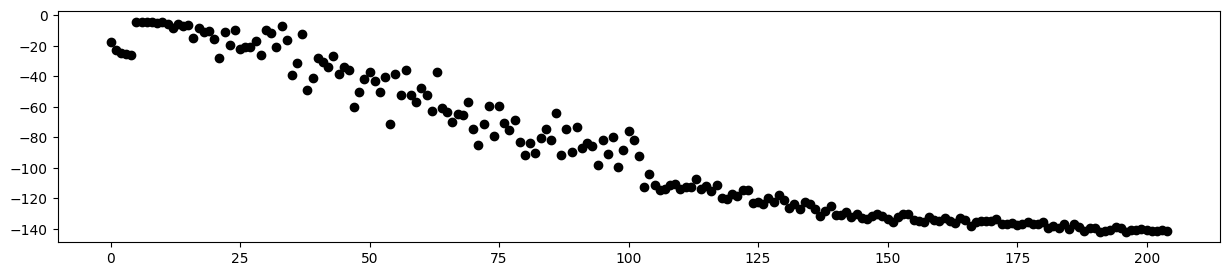

In [13]:
# Plot objective value vs time

plt.figure(figsize=(15, 3))
plt.scatter(range(objective.n), y.cpu().numpy(), color='black')
plt.show()

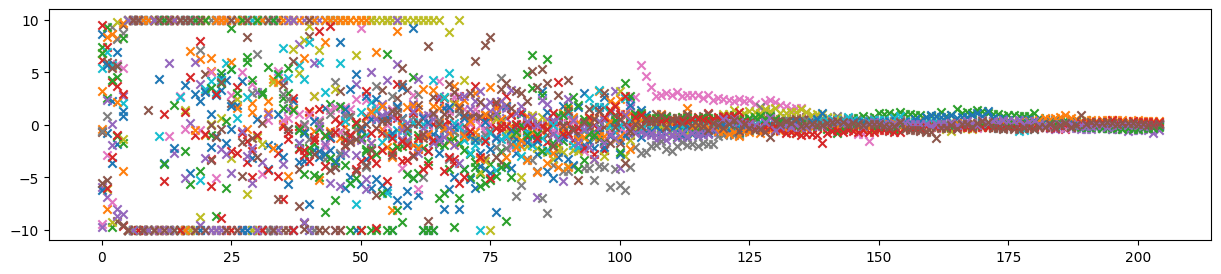

In [14]:
# Plot knobs vs time

plt.figure(figsize=(15, 3))
for k in x.T.cpu().numpy():
    plt.scatter(range(objective.n), k, marker='x')
plt.show()

# Example-10: RCDS with GP

In [1]:
# RCDS is a variation of Powell's method for noisy objectives
# It uses 1D minimization along conjugated set of directions
# Avaliable 1D minimization options are bracketing & weighted parabola fit and gaussian process & bayesian optimization
# Workflow for 1D minimization with parabola was described above
# GP & BO minimization was also used
# Here 1D minimization with GP & BO is described in more details
# Usage of GP & BO can potentialy reduce the number of samples and located global optimum

In [2]:
# Import

import numpy
import torch

from torch import Tensor

from rcds.statistics import mean, variance, median, biweight_midvariance
from rcds.wrapper import Wrapper
from rcds.minimizer import Minimizer

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

dtype = torch.float64
device = 'cpu'

True
16


In [3]:
# Minimize (bracketting & weighted parabola fit)

# Define objective {-0.702014, {x->1.10369, y->-1.10369}}

@Wrapper(cache=True, nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[1.0E-12, 1.0E-12], error=1.0E-6, dtype=dtype, device=device)
def objective(knobs):
    x, y = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2
    value += objective.error*torch.randn_like(value) 
    error = objective.error
    return value, error

# Minimize

objective()

minimizer = Minimizer(objective)

knobs = torch.tensor([-3.0, 4.0], dtype=dtype, device=device)
knobs = objective.forward(knobs)

matrix = torch.eye(minimizer.nk, dtype=dtype, device=device)

minimizer.rcds(knobs, matrix, ktol=1.0E-3, otol=1.0E-3)
_, value1, _ = minimizer.history()

EXIT: triggered knobs termination at iteration 4


In [4]:
# Minimize (gp & bo)

# Define objective {-0.702014, {x->1.10369, y->-1.10369}}

@Wrapper(cache=True, nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[1.0E-12, 1.0E-12], error=1.0E-6, dtype=dtype, device=device)
def objective(knobs):
    x, y = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2
    value += objective.error*torch.randn_like(value) 
    error = objective.error
    return value, error

# Minimize

objective()

minimizer = Minimizer(objective)

knobs = torch.tensor([-3.0, 4.0], dtype=dtype, device=device)
knobs = objective.forward(knobs)

matrix = torch.eye(minimizer.nk, dtype=dtype, device=device)

minimizer.rcds(
    knobs,
    matrix,
    ktol=1.0E-3,
    otol=1.0E-3,
    minimize=minimizer.minimize_gp,
    no_ucb=6,           # -- number of observations to perform with ucb af
    no_ei=0,            # -- number of observations to perform with ei af
    nr=64,              # -- number of restarts  in af optimization
    rs=256,             # -- number of raw samples in af optimization
    beta=1.0,           # -- ucb beta factor (large values encourage exploration, can be a vector tensor with length matching no_ucb)
    use_parabola=False, # -- flag to perfrom parabola fit
    np=1                # -- number of points (around current optimum) to use in parabola fit
)
_, value2, _ = minimizer.history()

EXIT: triggered value termination at iteration 4


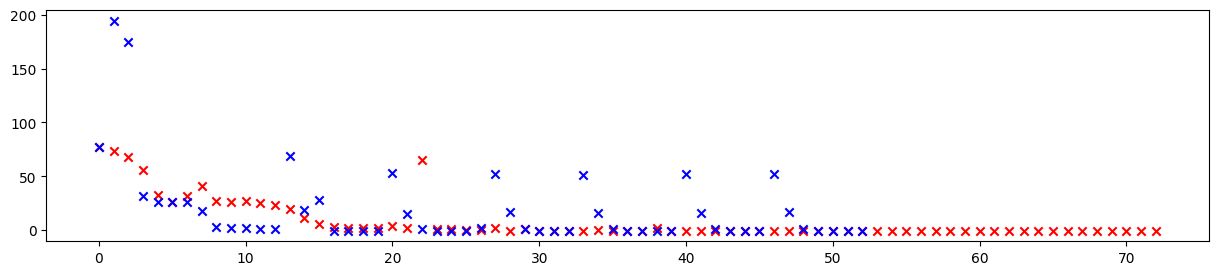

In [5]:
# Plot objective history

plt.figure(figsize=(15, 3))
plt.scatter(range(len(value1)), value1.cpu().numpy(), color='red', marker='x')
plt.scatter(range(len(value2)), value2.cpu().numpy(), color='blue', marker='x')
plt.show()

# Example-11: Derivative based minimization

In [1]:
# If objective derivatives are avaliable, it is possible to use different optimization methods based on derivatives
# Torch optimization methods are interfaced with minimizer.torch method
# Newton method is also available (it can be mapped over a set of initial guesses or other fixed objective tensor parameters)

In [2]:
# Import

import numpy
import torch

from torch import Tensor

from rcds.statistics import mean, variance, median, biweight_midvariance
from rcds.wrapper import Wrapper
from rcds.minimizer import Minimizer

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

dtype = torch.float64
device = 'cpu'

True
16


In [3]:
# Set objective 
# {-0.702014, {x->1.10369, y->-1.10369}}

def objective(knobs):
    x, y = knobs
    value = (x - 1.0)**2 + x*y + (y + 1.0)**2 + 1/3*x**2*y**2
    error = torch.zeros_like(value)
    return value, error

# Set wrapper

wrapper = Wrapper(cache=False)

# Wrap objective and attach attributes
# Note, derivative based methods are unbounded, input knobs are not normalized

objective = wrapper(objective, wrapped=False)
objective()

# Set minimizer

minimizer = Minimizer(objective)

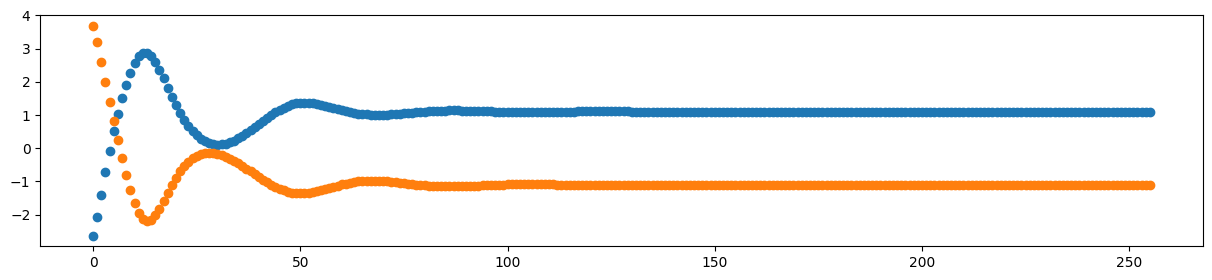

In [4]:
# SGD (torch)

knobs = torch.tensor([-3.0, 4.0], dtype=dtype, device=device)
knobs, value = minimizer.torch(knobs, 256, torch.optim.SGD, lr=0.01, momentum=0.9, dampening=0.1)

# Plot result

plt.figure(figsize=(15, 3))
for knob in knobs.T:
    plt.scatter(range(len(knob)), knob)
plt.show()

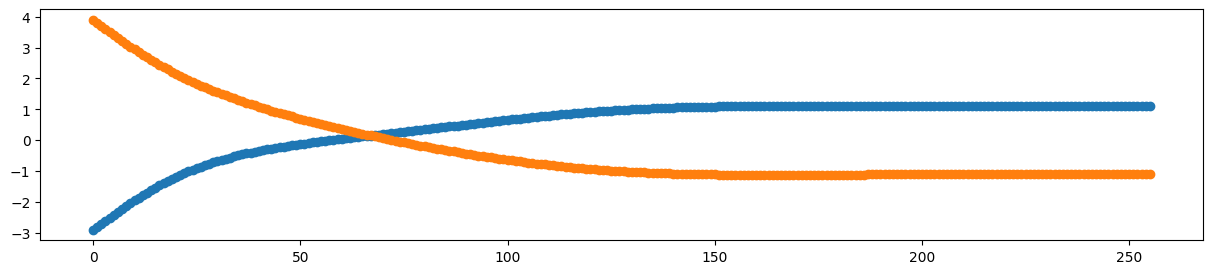

In [5]:
# Adam (torch)

knobs = torch.tensor([-3.0, 4.0], dtype=dtype, device=device)
knobs, value = minimizer.torch(knobs, 256, torch.optim.Adam, lr=0.1)

# Plot result

plt.figure(figsize=(15, 3))
for knob in knobs.T:
    plt.scatter(range(len(knob)), knob)
plt.show()

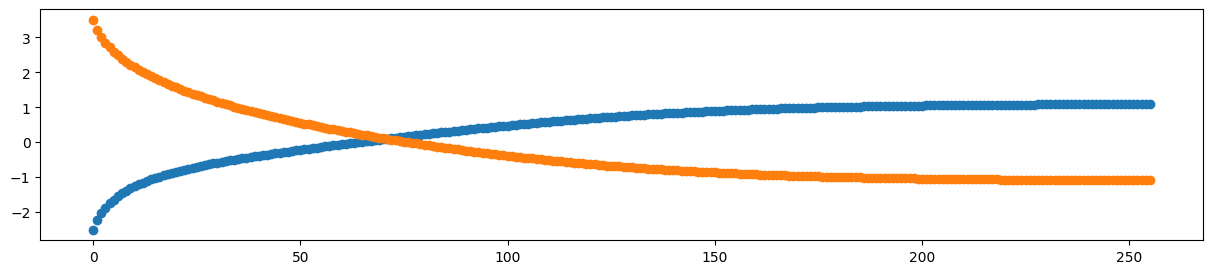

In [6]:
# Adagrad (torch)

knobs = torch.tensor([-3.0, 4.0], dtype=dtype, device=device)
knobs, value = minimizer.torch(knobs, 256, torch.optim.Adagrad, lr=0.5)

# Plot result

plt.figure(figsize=(15, 3))
for knob in knobs.T:
    plt.scatter(range(len(knob)), knob)
plt.show()

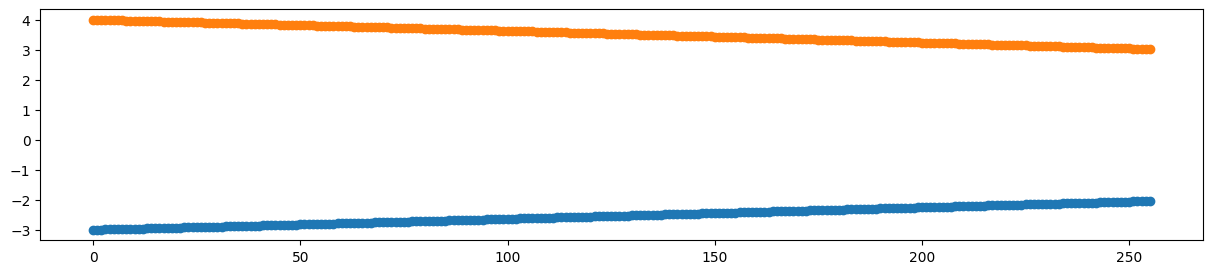

In [7]:
# Adadelta (torch)

knobs = torch.tensor([-3.0, 4.0], dtype=dtype, device=device)
knobs, value = minimizer.torch(knobs, 256, torch.optim.Adadelta)

# Plot result

plt.figure(figsize=(15, 3))
for knob in knobs.T:
    plt.scatter(range(len(knob)), knob)
plt.show()

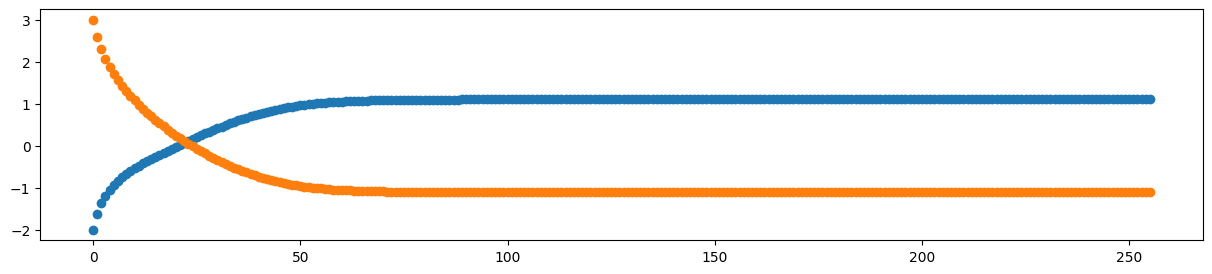

In [8]:
# RMSprop (torch)

knobs = torch.tensor([-3.0, 4.0], dtype=dtype, device=device)
knobs, value = minimizer.torch(knobs, 256, torch.optim.RMSprop, lr=0.1)

# Plot result

plt.figure(figsize=(15, 3))
for knob in knobs.T:
    plt.scatter(range(len(knob)), knob)
plt.show()

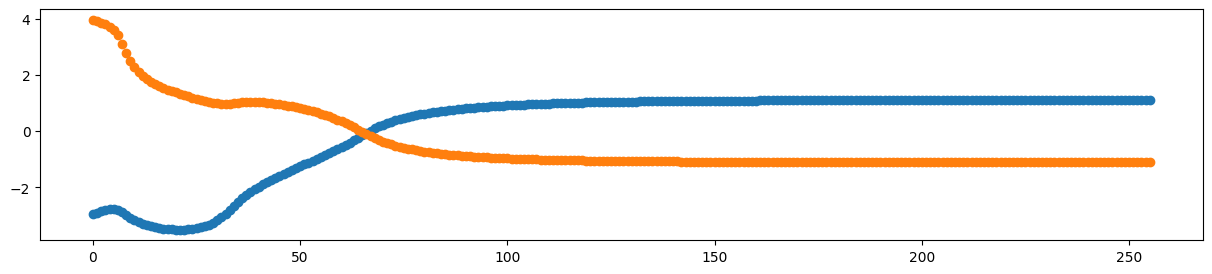

In [9]:
# LBFGS (torch)

knobs = torch.tensor([-3.0, 4.0], dtype=dtype, device=device)
knobs, value = minimizer.torch(knobs, 256, torch.optim.LBFGS, lr=0.01, max_iter=4, tolerance_grad=1.0E-9, tolerance_change=1.0E-12)

# Plot result

plt.figure(figsize=(15, 3))
for knob in knobs.T:
    plt.scatter(range(len(knob)), knob)
plt.show()

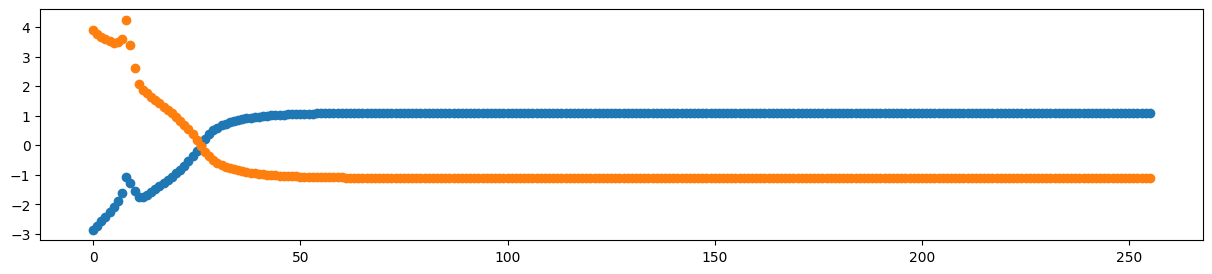

In [10]:
# Newton

knobs = torch.tensor([-3.0, 4.0], dtype=dtype, device=device)
knobs, value = minimizer.newton(knobs, torch.func.jacrev, count=256, factor=0.1, alpha=1.0E-3)

# Plot result

plt.figure(figsize=(15, 3))
for knob in knobs.T:
    plt.scatter(range(len(knob)), knob)
plt.show()

In [11]:
# Map a set of initial guessed over newton

knobs = torch.tensor([-3.0, 4.0], dtype=dtype, device=device) + 0.5*torch.randn((128, 2), dtype=dtype, device=device)
knobs, value = torch.func.vmap(lambda knobs: minimizer.newton(knobs, torch.func.jacrev, count=256, factor=0.1, alpha=1.0E-3))(knobs)

print(knobs.shape)
print(knobs.swapaxes(0, 1).shape)

torch.Size([128, 256, 2])
torch.Size([256, 128, 2])


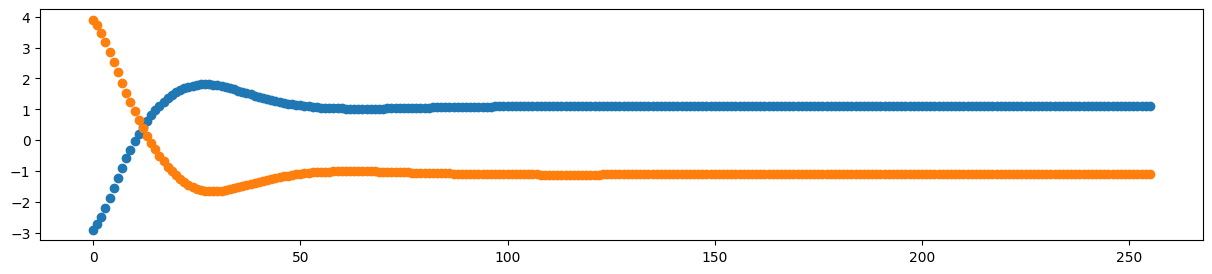

In [12]:
# Adam

knobs = torch.tensor([-3.0, 4.0], dtype=dtype, device=device)
knobs, value = minimizer.adam(knobs, torch.func.jacrev, count=256, lr=0.01)

# Plot result

plt.figure(figsize=(15, 3))
for knob in knobs.T:
    plt.scatter(range(len(knob)), knob)
plt.show()

In [13]:
# Map a set of initial guessed over adam

knobs = torch.tensor([-3.0, 4.0], dtype=dtype, device=device) + 0.5*torch.randn((128, 2), dtype=dtype, device=device)
knobs, value = torch.func.vmap(lambda knobs: minimizer.adam(knobs, torch.func.jacrev, count=256, lr=0.1))(knobs)

print(knobs.shape)
print(knobs.swapaxes(0, 1).shape)

torch.Size([128, 256, 2])
torch.Size([256, 128, 2])


# Example-12: Fit

In [1]:
# Import

import numpy
import torch

from torch import Tensor

from rcds.statistics import mean, variance, median, biweight_midvariance
from rcds.wrapper import Wrapper
from rcds.minimizer import Minimizer

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

dtype = torch.float64
device = 'cpu'

True
16


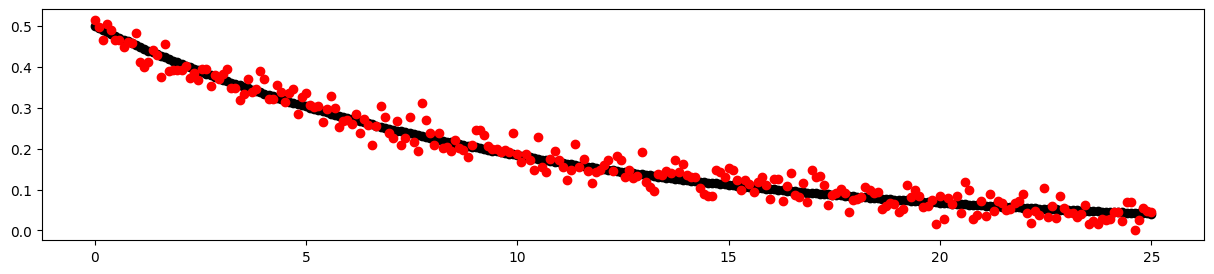

In [2]:
# Set model and generate data

def model(knobs, x):
    amplitude, decay = knobs
    return amplitude * torch.exp(-decay*x)

solution = torch.tensor([0.5, 0.1], dtype=dtype, device=device)

sigma = 0.025
x = torch.linspace(0.0, 25.0, 256, dtype=dtype, device=device)
y = model(solution, x) + sigma*torch.randn_like(x)

plt.figure(figsize=(15, 3))
plt.scatter(x.cpu().numpy(), model(solution, x).cpu().numpy(), color='black', marker='o')
plt.scatter(x.cpu().numpy(), y.cpu().numpy(), color='red', marker='o')
plt.show()

In [3]:
# Define objective

def objective(knobs, x, y):
    value = ((model(knobs, x) - y)**2).sum()
    error = torch.zeros_like(value)
    return value, error

# Define objective wrapper

wrapper = Wrapper(nk=2, lb=[0.0, 0.0], ub=[1.0, 1.0], dtype=dtype, device=device)

tensor([4.939859409670e-01, 9.690703345087e-02], dtype=torch.float64)
tensor([5.000000000000e-01, 1.000000000000e-01], dtype=torch.float64)


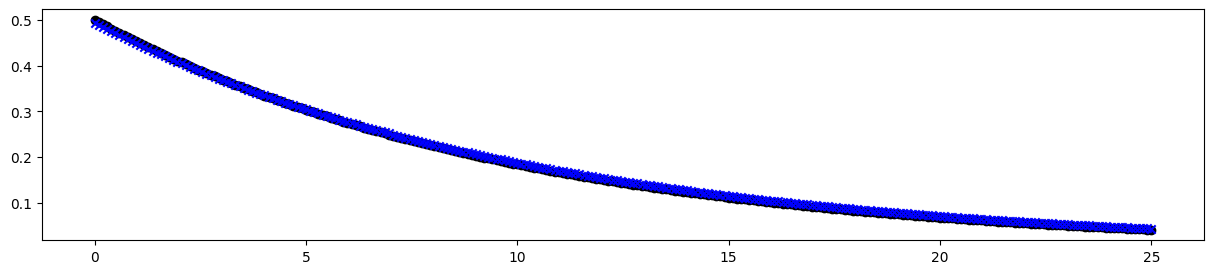

In [4]:
# RCDS

# Wrap objective

target = wrapper(objective)
target()

# Set minimizer

minimizer = Minimizer(target)

# Set initial knobs

knobs = torch.tensor([0.1, 0.0], dtype=dtype, device=device)
knobs = target.forward(knobs)

# Set directions

matrix = torch.eye(target.nk, dtype=dtype, device=device)

# Minimize

knobs, value, *_ = minimizer.rcds(knobs, matrix, x, y, ni=64, termination=False, warning=False, minimize=minimizer.minimize_parabola)
*_, knobs = knobs

# Compare

print(knobs)
print(solution)

plt.figure(figsize=(15, 3))
plt.scatter(x.cpu().numpy(), model(solution, x).cpu().numpy(), color='black', marker='o')
plt.scatter(x.cpu().numpy(), model(knobs, x).cpu().numpy(), color='blue', marker='x')
plt.show()

tensor([4.938852281248e-01, 9.686365668640e-02], dtype=torch.float64)
tensor([5.000000000000e-01, 1.000000000000e-01], dtype=torch.float64)


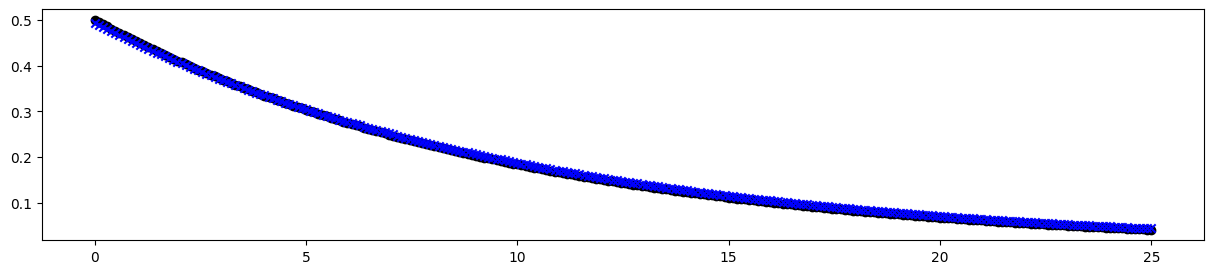

In [5]:
# Adam (torch)

# Wrap objective

target = wrapper(objective, wrapped=False)
target()

# Set minimizer

minimizer = Minimizer(target)

# Set initial knobs

knobs = torch.tensor([0.1, 0.0], dtype=dtype, device=device)

# Minimize

knobs, value, *_ = minimizer.torch(knobs, 256, torch.optim.Adam, x, y, lr=0.01)
*_, knobs = knobs

# Compare

print(knobs)
print(solution)

plt.figure(figsize=(15, 3))
plt.scatter(x.cpu().numpy(), model(solution, x).cpu().numpy(), color='black', marker='o')
plt.scatter(x.cpu().numpy(), model(knobs, x).cpu().numpy(), color='blue', marker='x')
plt.show()

tensor([4.938862438835e-01, 9.686387261505e-02], dtype=torch.float64)
tensor([5.000000000000e-01, 1.000000000000e-01], dtype=torch.float64)


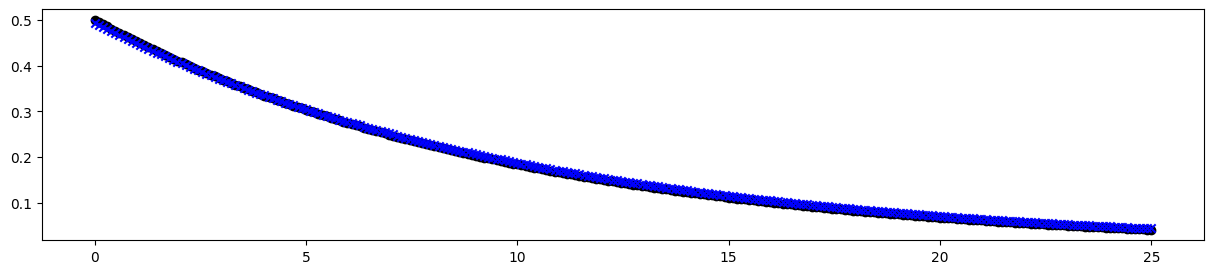

In [6]:
# Adam
# Note, can be mapped over initials and/or samples

# Wrap objective

target = wrapper(objective, wrapped=False)
target()

# Set minimizer

minimizer = Minimizer(target)

# Set initial knobs

knobs = torch.tensor([0.1, 0.0], dtype=dtype, device=device)

# Minimize

knobs, value, *_ = minimizer.adam(knobs, torch.func.jacrev, x, y, count=256, lr=0.001)
*_, knobs = knobs

# Compare

print(knobs)
print(solution)

plt.figure(figsize=(15, 3))
plt.scatter(x.cpu().numpy(), model(solution, x).cpu().numpy(), color='black', marker='o')
plt.scatter(x.cpu().numpy(), model(knobs, x).cpu().numpy(), color='blue', marker='x')
plt.show()

tensor([4.938814235836e-01, 9.686272129791e-02], dtype=torch.float64)
tensor([5.000000000000e-01, 1.000000000000e-01], dtype=torch.float64)


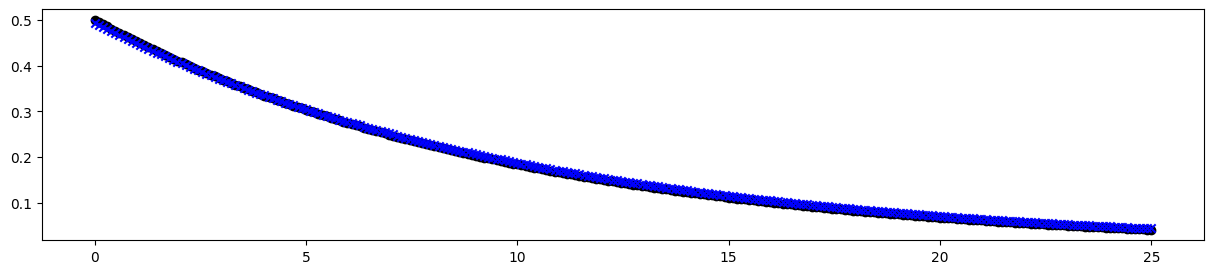

In [7]:
# LBFGS (torch)

# Wrap objective

target = wrapper(objective, wrapped=False)
target()

# Set minimizer

minimizer = Minimizer(target)

# Set initial knobs

knobs = torch.tensor([0.1, 0.0], dtype=dtype, device=device)

# Minimize

knobs, value, *_ = minimizer.torch(knobs, 16, torch.optim.LBFGS, x, y, lr=0.1)
*_, knobs = knobs

# Compare

print(knobs)
print(solution)

plt.figure(figsize=(15, 3))
plt.scatter(x.cpu().numpy(), model(solution, x).cpu().numpy(), color='black', marker='o')
plt.scatter(x.cpu().numpy(), model(knobs, x).cpu().numpy(), color='blue', marker='x')
plt.show()

tensor([4.928019408307e-01, 9.664550519402e-02], dtype=torch.float64)
tensor([5.000000000000e-01, 1.000000000000e-01], dtype=torch.float64)


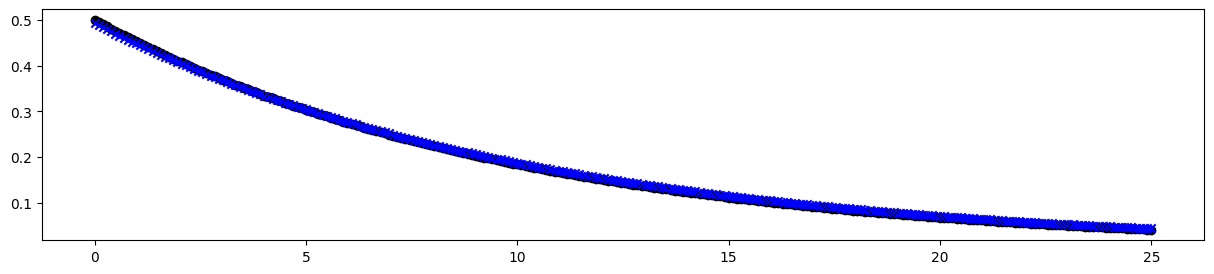

In [8]:
# Newton
# Note, can be mapped over initials and/or samples

# Wrap objective

target = wrapper(objective, wrapped=False)
target()

# Set minimizer

minimizer = Minimizer(target)

# Set initial knobs

knobs = torch.tensor([0.1, 0.0], dtype=dtype, device=device)

# Minimize

knobs, value, *_ = minimizer.newton(knobs, torch.func.jacfwd, x, y, count=64, factor=0.1, alpha=0.001)
*_, knobs = knobs

# Compare

print(knobs)
print(solution)

plt.figure(figsize=(15, 3))
plt.scatter(x.cpu().numpy(), model(solution, x).cpu().numpy(), color='black', marker='o')
plt.scatter(x.cpu().numpy(), model(knobs, x).cpu().numpy(), color='blue', marker='x')
plt.show()

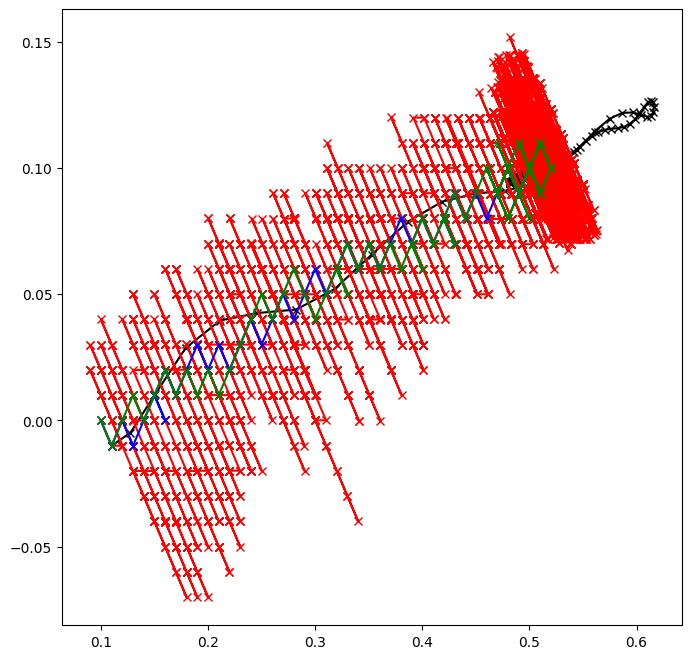

In [9]:
# In the above, full dataset was used duaring each iteration
# It is also possible to use only one data point or a subset of points (samples with replacement or data split into batches)

plt.figure(figsize=(8, 8))

# Adam (full data)

target = wrapper(objective, wrapped=False)
target()
minimizer = Minimizer(target)
start = torch.tensor([0.1, 0.0], dtype=dtype, device=device)
knobs, *_ = minimizer.adam(start, torch.func.jacrev, x, y, count=512, lr=0.001)
plt.plot(*knobs.T, color='black', marker='x')

# Adam (one data point)

target = wrapper(objective, wrapped=False)
target()
minimizer = Minimizer(target)
start = torch.tensor([0.1, 0.0], dtype=dtype, device=device)
knobs = []
knobs.append(start)
count = 2**16
for _ in range(count):
    i = torch.randint(len(x), (1, ))
    start, value, *_ = minimizer.adam(start, torch.func.jacrev, x[i], y[i], count=1, lr=0.001)
    *_, start = start
    knobs.append(start)
knobs = torch.stack(knobs)

plt.plot(*knobs.T, color='red', marker='x')

# Adam (samples with replacement)

target = wrapper(objective, wrapped=False)
target()
minimizer = Minimizer(target)
start = torch.tensor([0.1, 0.0], dtype=dtype, device=device)
knobs = []
knobs.append(start)
limit = 64
count = 2**10
for _ in range(count):
    i = torch.randint(len(x), (limit, ))
    start, value, *_ = minimizer.adam(start, torch.func.jacrev, x[i], y[i], count=1, lr=0.001)
    *_, start = start
    knobs.append(start)
knobs = torch.stack(knobs)

plt.plot(*knobs.T, color='blue', marker='x')

# Adam (batched)
# Note, not adaptive

target = wrapper(objective, wrapped=False)
target()
minimizer = Minimizer(target)
start = torch.tensor([0.1, 0.0], dtype=dtype, device=device)
knobs = []
knobs.append(start)

class Data(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        return x, y
    
data = Data(x, y)
load = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)

count = 128
for _ in range(count):
    for bx, by in load:
        start, value, *_ = minimizer.adam(start, torch.func.jacrev, bx, by, count=1, lr=0.001)
        *_, start = start
        knobs.append(start)
knobs = torch.stack(knobs)

plt.plot(*knobs.T, color='green', marker='x')

# Plot result

plt.show()

In [10]:
# Estimation of parameter errors

print(solution)
print()

# Estimate from variance-covariance matrix

target = wrapper(objective, wrapped=False)
target()
minimizer = Minimizer(target)
start = torch.tensor([0.1, 0.0], dtype=dtype, device=device)
knobs, *_ = minimizer.adam(start, torch.func.jacrev, x, y, count=512, lr=0.001)
*_, knobs = knobs

def target(knobs, x, y):
    value = ((model(knobs, x) - y)**2).sum()
    error = torch.zeros_like(value)
    return value

print(knobs)
print(minimizer.standard_errors(knobs, x, y, model, target, variance))
print()

# Estimate from data bootstrap

limit = len(x)
count = 2**10
index = torch.randint(limit, (count, limit), dtype=torch.int64, device=x.device)

target = wrapper(objective, wrapped=False)
target()
minimizer = Minimizer(target)
start = torch.tensor([0.1, 0.0], dtype=dtype, device=device)
knobs, _ = torch.func.vmap(lambda index: minimizer.adam(start, torch.func.jacrev, x[index], y[index], count=512, lr=0.001))(index)

print(torch.func.vmap(mean)(knobs[:, -1].T))
print((torch.func.vmap(variance)(knobs[:, -1].T)).sqrt())
print()

tensor([5.000000000000e-01, 1.000000000000e-01], dtype=torch.float64)

tensor([4.938855824507e-01, 9.686373064878e-02], dtype=torch.float64)
tensor([4.804849385610e-03, 1.431541381154e-03], dtype=torch.float64)

tensor([4.939799905004e-01, 9.689707210352e-02], dtype=torch.float64)
tensor([4.371729499204e-03, 1.364886528844e-03], dtype=torch.float64)



# Example-13: SCIPY vs RCDS (unfair)

In [1]:
# In this example RCDS and RCDS+GP methods are compared with scipy bounded minimization methods for 4D noisy objective function
# Note, RCDS+GP method is slow to evaluate (note, parabola fit might not be robust)
# Number of obervations for RCDS+GP should be increased for large noise level as well as beta ucb value
# Randomized initilal directions might be usefull too
# The point to use GP is to avoid local minimum trapping

In [2]:
# Import

import numpy
import torch

from torch import Tensor

from rcds.statistics import mean, variance, median, biweight_midvariance
from rcds.wrapper import Wrapper
from rcds.minimizer import Minimizer

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

dtype = torch.float64
device = 'cpu'

from scipy.special import j0

True
16


In [3]:
def benchmark(error:float) -> None:

    # Set noise

    error = error
    print(f'error        : {error:>12.9}')

    # Define objective function {0.0, {x1 -> 0.5, x2 -> 0.5, x3 -> 0.5, x4 -> -0.5}}
    # Xiaobiao Huang, Beam-based Correction and Optimization for Accelerators, p. 193

    def objective(knobs:Tensor) -> tuple[Tensor, Tensor]:
        x1, x2, x3, x4 = knobs.cpu().numpy()
        value = 0.5*(x1 + x2 - 1.0)**2 + 2.0*(x1 - x2)**2 + 0.1*(x1 - x4 - 1.0)**2
        value = 1.0 - numpy.exp(-(x3 + x4)**2)*j0(2.0*numpy.sqrt(value)) + 2.0*(x3 - 0.5)**2
        value = torch.tensor(value, dtype=knobs.dtype, device=knobs.device)
        value += error*torch.randn_like(value)
        return value, error
    
    # Define wrapper

    wrapper = Wrapper(cache=True, nk=4, lb=[-2.0, -2.0, -2.0, -2.0], ub=[+2.0, +2.0, +2.0, +2.0], error=error, dtype=dtype, device=device)

    # minimize('powell')

    obj = wrapper(objective)
    obj()
    
    knobs = torch.tensor([-0.5, 0.0, -0.5, 0.0], dtype=dtype, device=device)
    knobs = obj.forward(knobs)

    minimizer = Minimizer(obj)
    minimizer.scipy(knobs, method='powell')
    _, result_powell, _ = obj.history()
    print(f'powell       : {torch.log10(result_powell.abs()).min().cpu().item():>12.9}')
    
    # minimize('Nelder-Mead')

    obj = wrapper(objective)
    obj()

    knobs = torch.tensor([-0.5, 0.0, -0.5, 0.0], dtype=dtype, device=device)
    knobs = obj.forward(knobs)

    minimizer = Minimizer(obj)
    minimizer.scipy(knobs, method='Nelder-Mead')
    _, result_nelder_mead, _ = obj.history()
    print(f'Nelder-Mead  : {torch.log10(result_nelder_mead.abs()).min().cpu().item():>12.9}')
    
    # minimize('L-BFGS-B')

    obj = wrapper(objective)
    obj()

    knobs = torch.tensor([-0.5, 0.0, -0.5, 0.0], dtype=dtype, device=device)
    knobs = obj.forward(knobs)

    minimizer = Minimizer(obj)
    minimizer.scipy(knobs, method='L-BFGS-B')
    _, result_l_bfgs_b, _ = obj.history()
    print(f'L-BFGS-B     : {torch.log10(result_l_bfgs_b.abs()).min().cpu().item():>12.9}')
    
    # minimize('TNC')

    obj = wrapper(objective)
    obj()

    knobs = torch.tensor([-0.5, 0.0, -0.5, 0.0], dtype=dtype, device=device)
    knobs = obj.forward(knobs)

    minimizer = Minimizer(obj)
    minimizer.scipy(knobs, method='TNC')
    _, result_tnc, _ = obj.history()
    print(f'TNC          : {torch.log10(result_tnc.abs()).min().cpu().item():>12.9}')
    
    # minimize('SLSQP')

    obj = wrapper(objective)
    obj()

    knobs = torch.tensor([-0.5, 0.0, -0.5, 0.0], dtype=dtype, device=device)
    knobs = obj.forward(knobs)

    minimizer = Minimizer(obj)
    minimizer.scipy(knobs, method='SLSQP')
    _, result_slsqp, _ = obj.history()
    print(f'SLSQP        : {torch.log10(result_slsqp.abs()).min().cpu().item():>12.9}')
    
    # rcds-parabola

    obj = wrapper(objective)
    obj()

    minimizer = Minimizer(obj)

    knobs = torch.tensor([-0.5, 0.0, -0.5, 0.0], dtype=dtype, device=device)
    knobs = obj.forward(knobs)
    matrix = torch.eye(minimizer.nk, dtype=minimizer.dtype)

    minimizer.rcds(knobs, matrix, factor=1.0, np=2, ns=16, termination=False, minimize=minimizer.minimize_parabola, warning=False)
    
    _, result_rcds, _ = obj.history()
    print(f'rcds         : {torch.log10(result_rcds.abs()).min().cpu().item():>12.9}')
    
    # rcds-gp

    obj = wrapper(objective)
    obj()

    minimizer = Minimizer(obj)

    knobs = torch.tensor([-0.5, 0.0, -0.5, 0.0], dtype=dtype, device=device)
    knobs = obj.forward(knobs)
    matrix = torch.eye(minimizer.nk, dtype=minimizer.dtype)

    minimizer.rcds(knobs, matrix, factor=1.0, no_ucb=8, no_ei=8, beta=25.0, termination=False, minimize=minimizer.minimize_gp, warning=False)
    
    _, result_rcds_gp, _ = obj.history()
    print(f'rcds_gp      : {torch.log10(result_rcds_gp.abs()).min().cpu().item():>12.9}')

    # Show result

    plt.figure(figsize=(15, 3))
    plt.scatter(range(len(result_powell)), torch.log10(result_powell.abs()).cpu().numpy(), color='black', marker='x', label='powell')
    plt.scatter(range(len(result_nelder_mead)), torch.log10(result_nelder_mead.abs()).cpu().numpy(), color='red', marker='x', label='Nelder-Mead')
    plt.scatter(range(len(result_l_bfgs_b)), torch.log10(result_l_bfgs_b.abs()).cpu().numpy(), color='blue', marker='x', label='L-BFGS-B')
    plt.scatter(range(len(result_tnc)), torch.log10(result_tnc.abs()).cpu().numpy(), color='green', marker='x', label='TNC')
    plt.scatter(range(len(result_slsqp)), torch.log10(result_slsqp.abs()).cpu().numpy(), color='magenta', marker='x', label='SLSQP')
    plt.scatter(range(len(result_rcds)), torch.log10(result_rcds.abs()).cpu().numpy(), color='black', marker='o', label='rcds')
    plt.scatter(range(len(result_rcds_gp)), torch.log10(result_rcds_gp.abs()).cpu().numpy(), color='blue', marker='o', label='rcds-gp')
    plt.legend(loc='best')
    plt.show()

error        :        1e-06
powell       :  -8.90043772
Nelder-Mead  :  -0.15497455
L-BFGS-B     :  0.493857745
TNC          :   0.49385771
SLSQP        : -0.274507197
rcds         :  -7.77505067
rcds_gp      :  -7.54598612


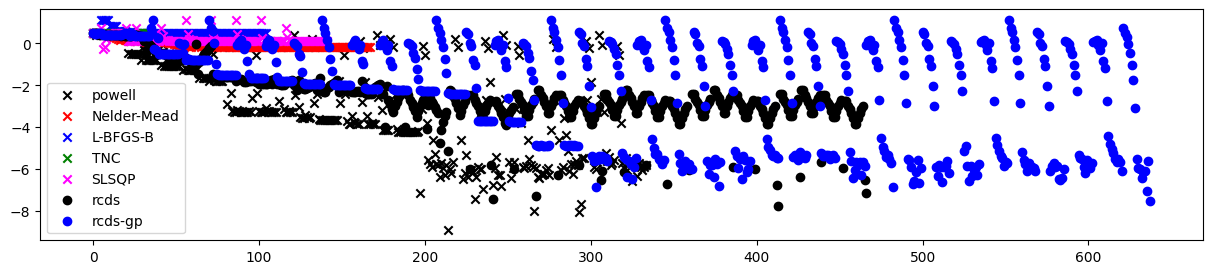

CPU times: user 7min 54s, sys: 504 ms, total: 7min 55s
Wall time: 30.4 s


In [4]:
%%time
error = 1.0E-6
benchmark(error)

error        :        0.001
powell       :  -5.03558041
Nelder-Mead  :  -6.84038027
L-BFGS-B     : 0.0178133353
TNC          :  0.493517295
SLSQP        :   0.49357152
rcds         :  -5.05040438
rcds_gp      :  -5.46783483


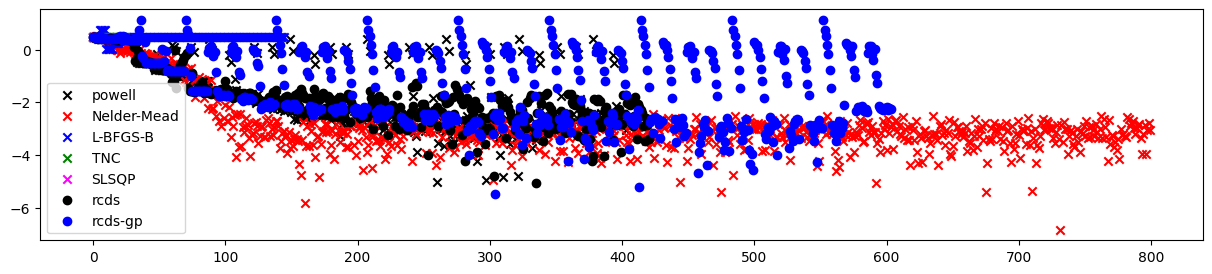

CPU times: user 7min 6s, sys: 392 ms, total: 7min 7s
Wall time: 27.4 s


In [5]:
%%time
error = 1.0E-3
benchmark(error)

error        :         0.01
powell       :  -4.27727279
Nelder-Mead  : -0.162396706
L-BFGS-B     :  0.121910759
TNC          :  0.490751428
SLSQP        :  0.491791693
rcds         :  -4.21175466
rcds_gp      :  -4.90765645


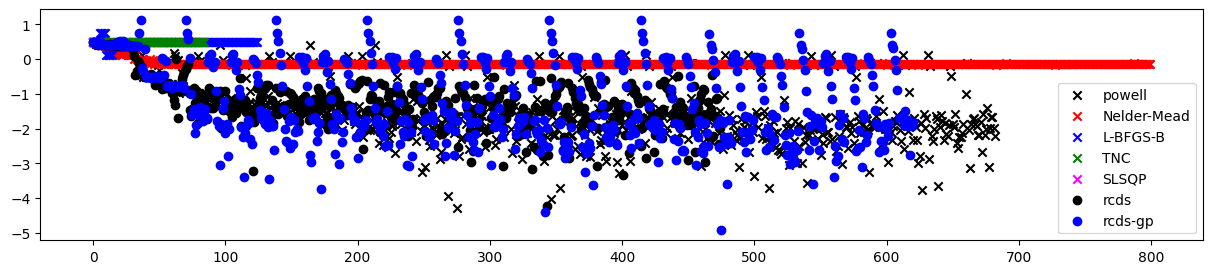

CPU times: user 7min 50s, sys: 511 ms, total: 7min 51s
Wall time: 30.2 s


In [6]:
%%time
error = 1.0E-2
benchmark(error)

error        :          0.1
powell       :  -3.77617546
Nelder-Mead  : -0.0804823908
L-BFGS-B     :  0.190754149
TNC          :  0.472678887
SLSQP        :   0.47338466
rcds         :  -3.02452769
rcds_gp      :  -3.46476681


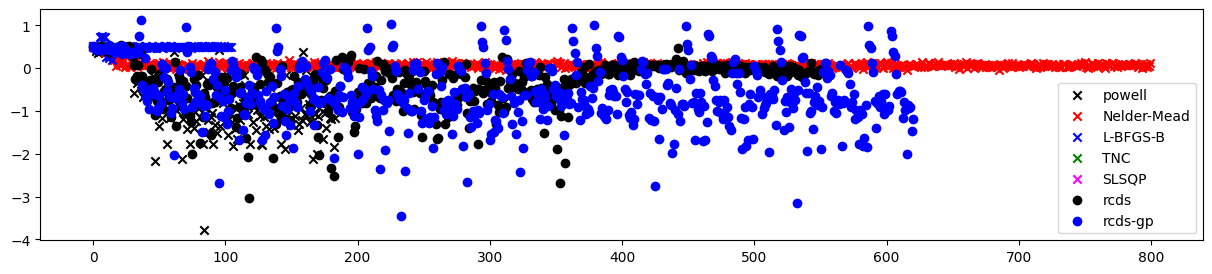

CPU times: user 11min 13s, sys: 405 ms, total: 11min 14s
Wall time: 42.8 s


In [7]:
%%time
error = 1.0E-1
benchmark(error)